# Telecom Churn Analysis and Prediction using Cost Sensitive Learning
Notebook link: https://www.kaggle.com/code/para24/churn-prediction-using-cost-sensitive-learning

**Highlights:**
> 1. Correlation analysis using Pearson coefficient for continuous features and Cramer's V for categorical features
>
> 2. Data visualization using Seaborn FacetGrid plots
>
> 3. Classification of the imbalanced dataset using `class weighted` or `cost sensitive` learning
>
> 4. Classifier performance analysis using ***`revenue weighted recall score`*** and ***`revenue retained per customer`*** metrics
>
> 5. Rationale for choosing Logistic Regression as an optimal classifier for the churn prediction problem
>
> 6. Results for each ML algorithm are presented after performing 5-fold cross validation based on F1-score
>
For a similar analysis using SMOTE data see [here](https://www.kaggle.com/para24/telecom-churn-analysis-and-prediction-smote-data).

* [1.  Import and Clean data](#import-and-clean-data)
    * [1.1.  Delete `customerid` column](#delete-%60customerid%60-column)
    * [1.2.  Data Munging](#data-munging)
        * [1.2.1.  Checking for null values in the dataset](#checking-for-null-values-in-the-dataset)
        * [1.2.2.  Making labels concise](#making-labels-concise)
        * [1.2.3.  Column Type Casting and Imputation](#column-type-casting-and-imputation)
            * [1.2.3.1.  Cast `TotalCharges` column to `float`](#cast-%60totalcharges%60-column-to-%60float%60)
            * [1.2.3.2.  Search for categorical columns and cast them to `pd.Categorical`](#search-for-categorical-columns-and-cast-them-to-%60pd.categorical%60)
        * [1.2.4.  Reordering Columns](#reordering-columns)
* [2.  Correlations in the data](#correlations-in-the-data)
    * [2.1.  Correlation between Quantitative variables](#correlation-between-quantitative-variables)
    * [2.2.  Correlation between Qualitative/ Categorical variables](#correlation-between-qualitative/-categorical-variables)
* [3.  Data Visualization](#data-visualization)
    * [3.1.  Frequency distribution: categorical variables](#frequency-distribution%3A-categorical-variables)
    * [3.2.  Frequency distribution: monthlycharges and tenure](#frequency-distribution%3A-monthlycharges-and-tenure)
    * [3.3.  Box Plots](#box-plots)
    * [3.4.  Contribution to churned revenue](#contribution-to-churned-revenue)
    * [3.5.  Churn among different contract types](#churn-among-different-contract-types)
    * [3.6.  Churn among various categories and their contribution to (monthly) revenue](#churn-among-various-categories-and-their-contribution-to-%28monthly%29-revenue)
    * [3.7.  Churn among phone service, multiple lines, and internet service](#churn-among-phone-service%2C-multiple-lines%2C-and-internet-service)
    * [3.8.  Churn among phone service, internet service, and seniorcitizen](#churn-among-phone-service%2C-internet-service%2C-and-seniorcitizen)
    * [3.9.  Churn among phone service, internet service, and gender](#churn-among-phone-service%2C-internet-service%2C-and-gender)
    * [3.10.  Churn among internet service, streamingtv, and streamingmovies](#churn-among-internet-service%2C-streamingtv%2C-and-streamingmovies)
    * [3.11.  Churn among contract and internet service](#churn-among-contract-and-internet-service)
* [4.  Data Preprocessing](#data-preprocessing)
    * [4.1.  Train-Test split](#train-test-split)
    * [4.2.  One-hot Encoding and Standardization](#one-hot-encoding-and-standardization)
* [5.  Data Modeling](#data-modeling)
    * [5.1.  Utility Functions](#utility-functions)
    * [5.2.  Naive Bayes](#naive-bayes)
    * [5.3.  Logistic Regression](#logistic-regression)
    * [5.4.  K-Nearest Neighbors](#k-nearest-neighbors)
    * [5.5.  Decision Tree](#decision-tree)
    * [5.6.  Decision Trees with Bagging](#decision-trees-with-bagging)
    * [5.7.  Random Forests](#random-forests)
    * [5.8.  Decision Trees with AdaBoost](#decision-trees-with-adaboost)
    * [5.9.  Linear SVC](#linear-svc)
    * [5.10.  SVM with RBF kernel](#svm-with-rbf-kernel)
    * [5.11.  XGBoost](#xgboost)
    * [5.12.  CatBoost](#catboost)
* [6.  Model Comparison](#model-comparison)
    * [6.1.  Evaluation Metrics](#evaluation-metrics)
    * [6.2.  ROC and PR Curves](#roc-and-pr-curves)
* [7.  Further Analysis](#further-analysis)
* [8.  Which model to choose?](#which-model-to-choose%3F)

In [31]:
import os, sys

import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id="import-and-clean-data"></a>
# 1.  Import and Clean data

In [2]:
df = pd.read_csv('data/telco_data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<a id="delete-%60customerid%60-column"></a>
## 1.1.  Delete `customerid` column
Since 'customerid' column does not provide any relevant information in predicting the customer churn, we can delete the column.

In [3]:
df.drop(labels=['customerID'], axis=1, inplace=True)
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


<a id="data-munging"></a>
## 1.2.  Data Munging

<a id="checking-for-null-values-in-the-dataset"></a>
### 1.2.1.  Checking for null values in the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


As of now we don't see any null values. However, we will find a few in the `TotalCharges` column after casting it to `float64`

<a id="making-labels-concise"></a>
### 1.2.2.  Making labels concise
Let's make the categorical labels more concise. For instance, we will convert the categorical label `'Bank transfer (automatic)'` to `'Bank transfer'` to make it easier to access (and display) during visualization.

In [5]:
## Shorten the Labels
value_mapper = {'Female': 'F', 'Male': 'M', 'Yes': 'Y', 'No': 'N',
                'No phone service': 'No phone', 'Fiber optic': 'Fiber',
                'No internet service': 'No internet', 'Month-to-month': 'Monthly',
                'Bank transfer (automatic)': 'Bank transfer',
                'Credit card (automatic)': 'Credit card',
                'One year': '1 yr', 'Two year': '2 yr'}
df.replace(to_replace=value_mapper, inplace=True)
# Another method
# df = df.applymap(lambda v: value_mapper[v] if v in value_mapper.keys() else v)

Let's also change column labels from `TitleCase` to `lowercase` to ease access.

In [6]:
df.columns = [label.lower() for label in df.columns]
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
gender,F,M,M,M,F,F,M,F,F,M
seniorcitizen,0,0,0,0,0,0,0,0,0,0
partner,Y,N,N,N,N,N,N,N,Y,N
dependents,N,N,N,N,N,N,Y,N,N,Y
tenure,1,34,2,45,2,8,22,10,28,62
phoneservice,N,Y,Y,N,Y,Y,Y,N,Y,Y
multiplelines,No phone,N,N,No phone,N,Y,Y,No phone,Y,N
internetservice,DSL,DSL,DSL,DSL,Fiber,Fiber,Fiber,DSL,Fiber,DSL
onlinesecurity,N,Y,Y,Y,N,N,N,Y,N,Y
onlinebackup,Y,N,Y,N,N,N,Y,N,N,Y


<a id="column-type-casting-and-imputation"></a>
### 1.2.3.  Column Type Casting and Imputation
Pandas couldn't properly cast the data type of several columns. For instance, the `TotalCharges` column is recognized as `object` instead of `float`. Similarly, all the categorical columns were casted as `object` type instead of `pd.Categorical`.

<a id="cast-%60totalcharges%60-column-to-%60float%60"></a>
#### 1.2.3.1.  Cast `TotalCharges` column to `float`

In [7]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: totalcharges, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


Here we see that the `totalcharges` has 11 missing values. Let's see the complete data corresponding to these customers.

In [9]:
df[np.isnan(df['totalcharges'])]

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,F,0,Y,Y,0,N,No phone,DSL,Y,N,Y,Y,Y,N,2 yr,Y,Bank transfer,52.55,NaN,N
753,M,0,N,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,20.25,NaN,N
936,F,0,Y,Y,0,Y,N,DSL,Y,Y,Y,N,Y,Y,2 yr,N,Mailed check,80.85,NaN,N
1082,M,0,Y,Y,0,Y,Y,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,25.75,NaN,N
1340,F,0,Y,Y,0,N,No phone,DSL,Y,Y,Y,Y,Y,N,2 yr,N,Credit card,56.05,NaN,N
3331,M,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,19.85,NaN,N
3826,M,0,Y,Y,0,Y,Y,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,25.35,NaN,N
4380,F,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,20.00,NaN,N
5218,M,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,1 yr,Y,Mailed check,19.70,NaN,N
6670,F,0,Y,Y,0,Y,Y,DSL,N,Y,Y,Y,Y,N,2 yr,N,Mailed check,73.35,NaN,N


It can also be noted that the `Tenure` column is 0 for these entries even though the `monthlycharges` column is not empty. Let's see if there are any other 0 values in the `tenure` column.

In [10]:
df[df['tenure'] == 0].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

There are no additional missing values in the `Tenure` column. Let's delete the rows with missing values in `monthlycharges` and `tenure` columns.

In [11]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Index([], dtype='int64')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   seniorcitizen     7032 non-null   int64  
 2   partner           7032 non-null   object 
 3   dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   phoneservice      7032 non-null   object 
 6   multiplelines     7032 non-null   object 
 7   internetservice   7032 non-null   object 
 8   onlinesecurity    7032 non-null   object 
 9   onlinebackup      7032 non-null   object 
 10  deviceprotection  7032 non-null   object 
 11  techsupport       7032 non-null   object 
 12  streamingtv       7032 non-null   object 
 13  streamingmovies   7032 non-null   object 
 14  contract          7032 non-null   object 
 15  paperlessbilling  7032 non-null   object 
 16  paymentmethod     7032 non-null   object 
 17  

<a id="search-for-categorical-columns-and-cast-them-to-%60pd.categorical%60"></a>
#### 1.2.3.2.  Search for categorical columns and cast them to `pd.Categorical`
We need to manually identify categorical columns in the data before casting them to `pd.Categorical`. Casting categorical columns from the detected *object* type to *categorical* will ease visualization.

In [13]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def find_categorical(df, cutoff=10):
    """
        Function to find categorical columns in the dataframe.
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [18]:
summarize_categoricals(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
gender,"[F, M]",2,0
seniorcitizen,"[0, 1]",2,0
partner,"[Y, N]",2,0
dependents,"[N, Y]",2,0
tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",72,0
phoneservice,"[N, Y]",2,0
multiplelines,"[No phone, N, Y]",3,0
internetservice,"[DSL, Fiber, N]",3,0
onlinesecurity,"[N, Y, No internet]",3,0
onlinebackup,"[Y, N, No internet]",3,0


In [19]:
df = to_categorical(find_categorical(df), df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   seniorcitizen     7032 non-null   category
 2   partner           7032 non-null   category
 3   dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   phoneservice      7032 non-null   category
 6   multiplelines     7032 non-null   category
 7   internetservice   7032 non-null   category
 8   onlinesecurity    7032 non-null   category
 9   onlinebackup      7032 non-null   category
 10  deviceprotection  7032 non-null   category
 11  techsupport       7032 non-null   category
 12  streamingtv       7032 non-null   category
 13  streamingmovies   7032 non-null   category
 14  contract          7032 non-null   category
 15  paperlessbilling  7032 non-null   category
 16  paymentmethod     7032 non-nu

<a id="reordering-columns"></a>
### 1.2.4.  Reordering Columns

In [20]:
new_order = list(df.columns)
new_order.insert(16, new_order.pop(4))
df = df[new_order]
df.head(2)

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,tenure,monthlycharges,totalcharges,churn
0,F,0,Y,N,N,No phone,DSL,N,Y,N,N,N,N,Monthly,Y,Electronic check,1,29.85,29.85,N
1,M,0,N,N,Y,N,DSL,Y,N,Y,N,N,N,1 yr,N,Mailed check,34,56.95,1889.50,N


<a id="correlations-in-the-data"></a>
# 2.  Correlations in the data

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthlycharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
totalcharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


<a id="correlation-between-quantitative-variables"></a>
## 2.1.  Correlation between Quantitative variables

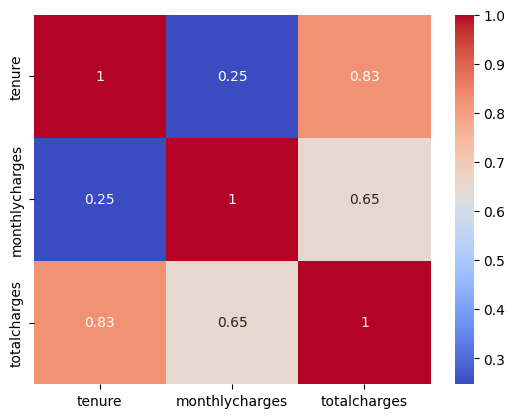

In [22]:
sns.heatmap(data=df[['tenure', 'monthlycharges', 'totalcharges']].corr(),
            annot=True, cmap='coolwarm');

***Inference:*** As evident from the correlation matrix and regplots, since ***'totalcharges'*** is the total monthly charges over the tenure of a customer, ***'totalcharges'*** is highly correlated with ***'monthlycharges'*** and ***'tenure'***.

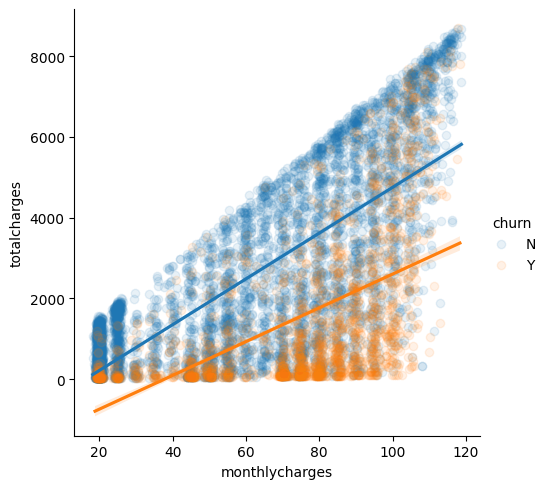

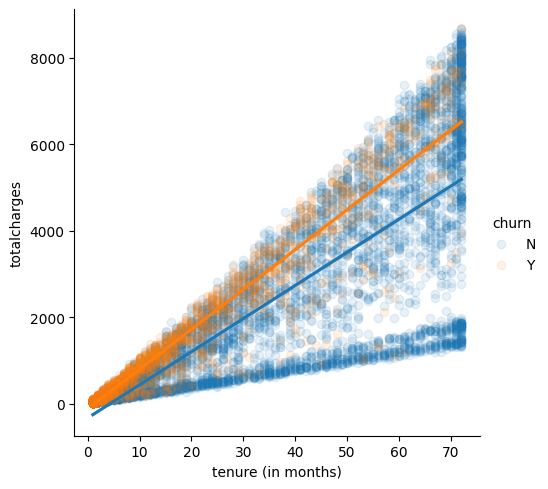

In [25]:
sns.lmplot(x='monthlycharges', y='totalcharges', data=df, hue='churn',
           scatter_kws={'alpha': 0.1})
fig = sns.lmplot(x='tenure',y= 'totalcharges', data=df, hue='churn',
                 scatter_kws={'alpha': 0.1})
fig.set_xlabels('tenure (in months)');

<a id="correlation-between-qualitative/-categorical-variables"></a>
## 2.2.  Correlation between Qualitative/ Categorical variables
`Cramer's V` is more appropriate than Pearson correlation to find correlation between two nominal variables. Here, the `Cramer's V` metric is implemented.

In [26]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [27]:
def categorical_corr_matrix(df):
    """
        Computes corrected Cramer's V statistic between
        all the categorical variables in the dataframe
    """
    df = df.select_dtypes(include='category')
    cols = df.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            df_crosstab = pd.crosstab(df[col1], df[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(df_crosstab)
    
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

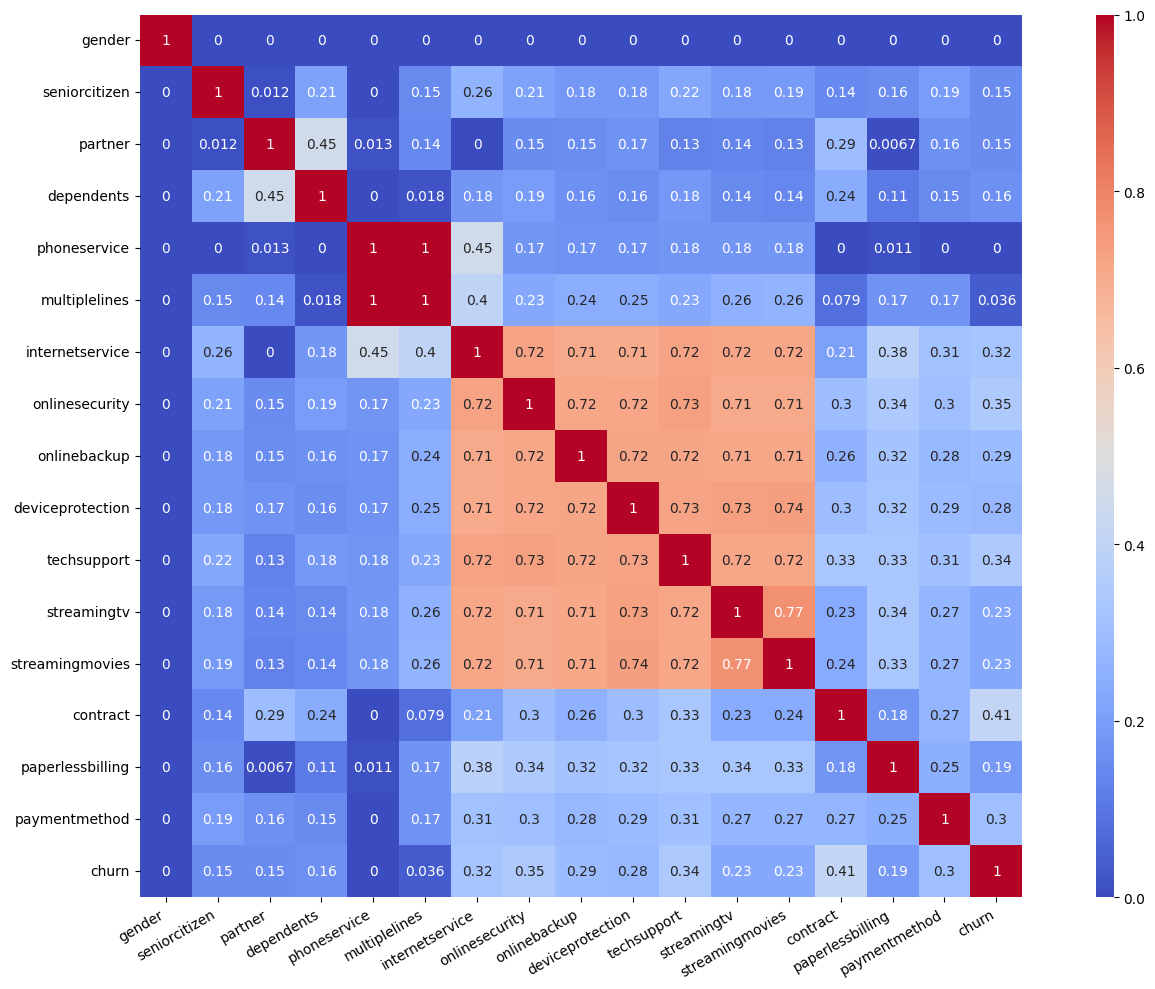

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(categorical_corr_matrix(df), annot=True, cmap='coolwarm', 
            cbar_kws={'aspect': 50}, square=True, ax=ax)
plt.xticks(rotation=30, ha='right');
plt.tight_layout()

***Inference:*** There is some correlation between *'phone service'* and *'multiple lines'* since those who don't have a phone service cannot have multiple lines. So, knowing that a particular customer is not subscribed to phone service we can infer that the customer doesn't have multiple lines. Similarly, there is also a correlation between *'internet service'* and *'online security', 'online backup', 'device protection', 'streaming tv'* and *'streaming movies'*

<a id="data-visualization"></a>
# 3.  Data Visualization

<a id="frequency-distribution%3A-categorical-variables"></a>
## 3.1.  Frequency distribution: categorical variables

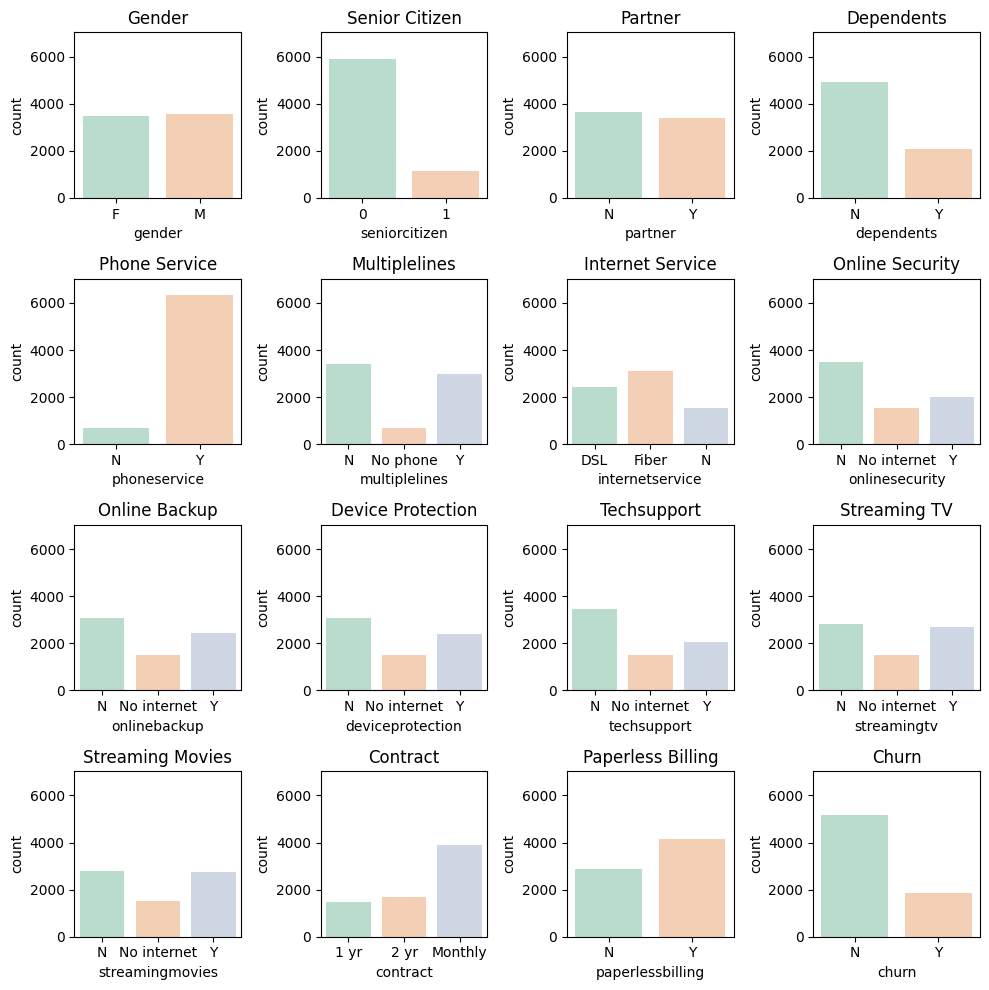

In [32]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
titles = ['Gender', 'Senior Citizen', 'Partner', 'Dependents',
          'Phone Service', 'Multiplelines', 'Internet Service', 'Online Security',
          'Online Backup', 'Device Protection', 'Techsupport', 'Streaming TV',
          'Streaming Movies', 'Contract', 'Paperless Billing', 'Churn']

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.countplot(x=''.join(title.lower().split()), data=df, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 7032)

plt.tight_layout()

***Inference:*** The dataset is imbalanced as can be seen from the Churn plot (bottom right corner).

<a id="frequency-distribution%3A-monthlycharges-and-tenure"></a>
## 3.2.  Frequency distribution: monthlycharges and tenure

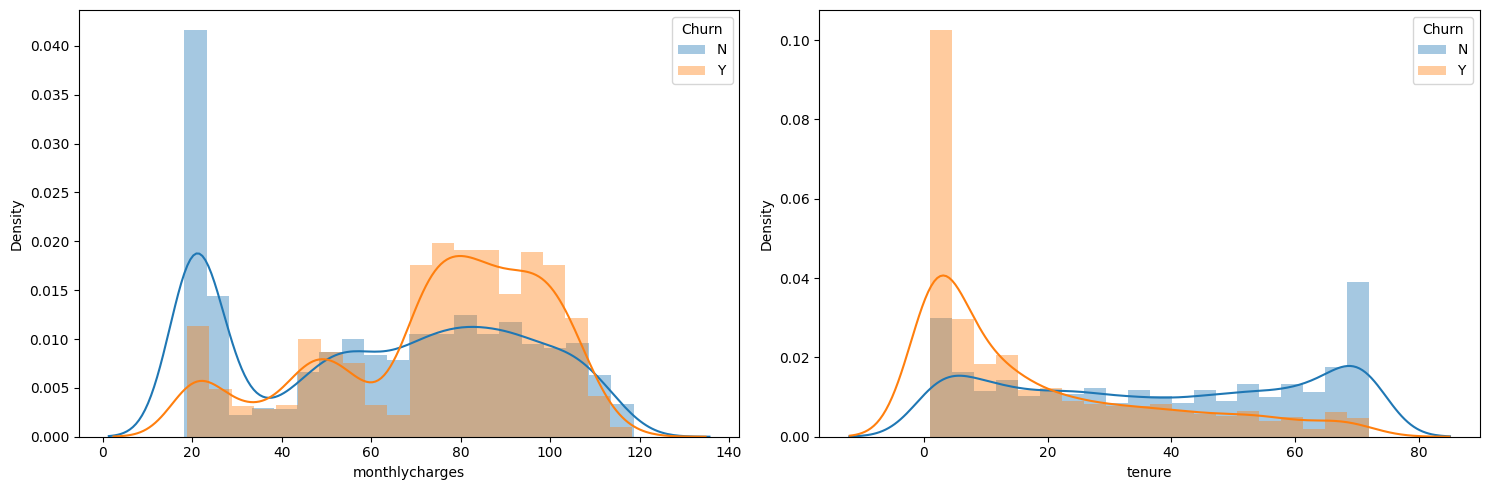

In [35]:
df_grouped = df.groupby(by='churn')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
cols = ['monthlycharges', 'tenure']
for i in range(len(cols)):
    sns.distplot(df_grouped.get_group('N')[cols[i]], bins=20, ax=axes[i], label='N')
    sns.distplot(df_grouped.get_group('Y')[cols[i]], bins=20, ax=axes[i], label='Y')
    axes[i].legend(title='Churn')

fig.tight_layout()

***Inference:*** We can say that most churn customers have monthly charges of around 70 to 110 and a tenure of around 0 to 20 months.

<a id="box-plots"></a>
## 3.3.  Box Plots

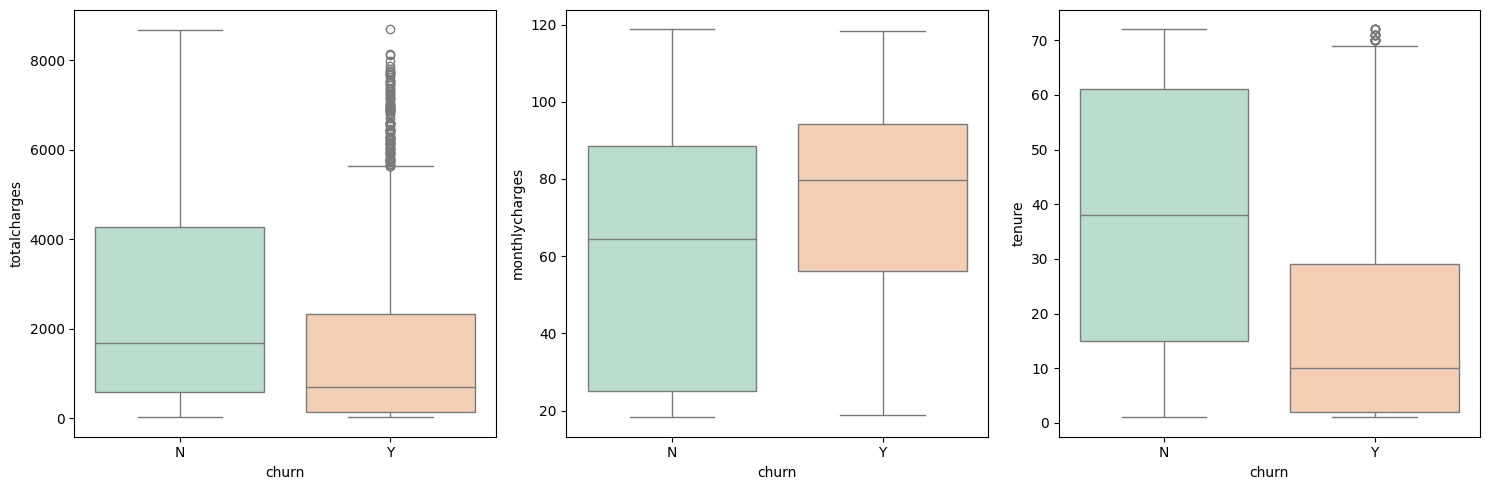

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
cols = ['totalcharges', 'monthlycharges', 'tenure']
for i in range(len(cols)):
    sns.boxplot(x='churn', y=cols[i], data=df, ax=axes[i], palette='Pastel2')
fig.tight_layout()

<a id="contribution-to-churned-revenue"></a>
## 3.4.  Contribution to churned revenue
Following graph represents percent contributed by customers in each tenure bin to the lost/ churned revenue.

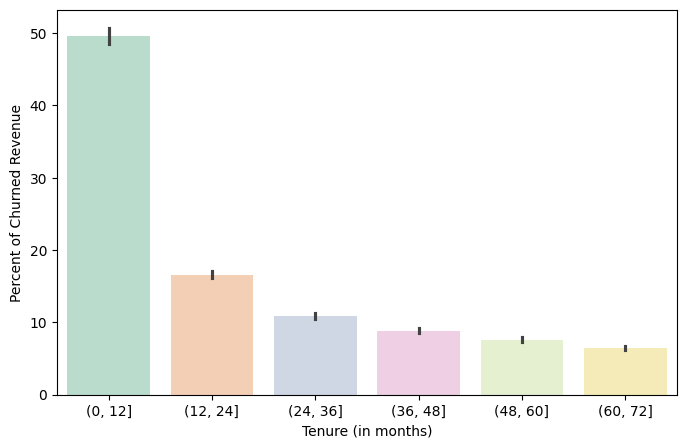

In [43]:
churned_users = df_grouped.get_group('Y')
bins = [(0, 12), (12, 24), (24, 36), (36, 48), (48, 60), (60, 72)]
binned_tenure = pd.cut(list(churned_users['tenure']),
                       bins=pd.IntervalIndex.from_tuples(bins))
revenue_share = churned_users['monthlycharges'] / churned_users['monthlycharges'].sum()
temp_df = pd.DataFrame(data={'tenure':binned_tenure, 
                             'revenue_share(%)': revenue_share * 100})


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.barplot(x='tenure', y='revenue_share(%)', data=temp_df,
            estimator=np.sum, palette='Pastel2', ax=ax)
ax.set_xlabel('Tenure (in months)')
ax.set_ylabel('Percent of Churned Revenue');

***Inference:*** Within the churned customers, 50% of the churned revenue is contributed by short tenure customers. This also means that the monthly charges of short tenure customers are more than high tenure customers. Therefore, if the ML models are successful in identifying the low tenure customers, then a major chunk of the revenue can be retained.

<a id="churn-among-different-contract-types"></a>
## 3.5.  Churn among different contract types

contract,1 yr,2 yr,Monthly
churn,,,
N,1306,1637,2220
Y,166,48,1655


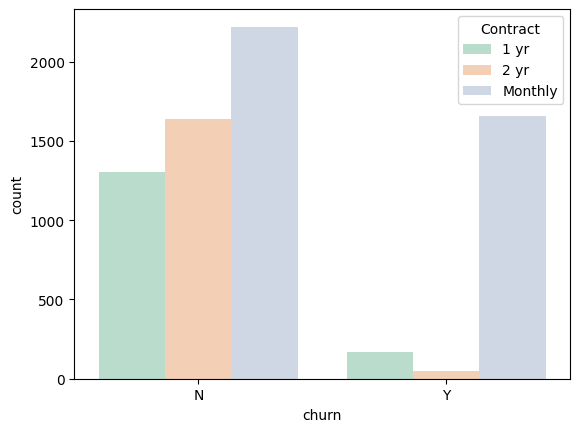

In [44]:
display(pd.crosstab(df['churn'], df['contract'], dropna=False))
sns.countplot(x='churn', hue='contract', data=df, palette='Pastel2')

# Put the legend out of the figure
plt.legend(title='Contract', bbox_to_anchor=(1, 1));

<a id="churn-among-various-categories-and-their-contribution-to-%28monthly%29-revenue"></a>
## 3.6.  Churn among various categories and their contribution to (monthly) revenue

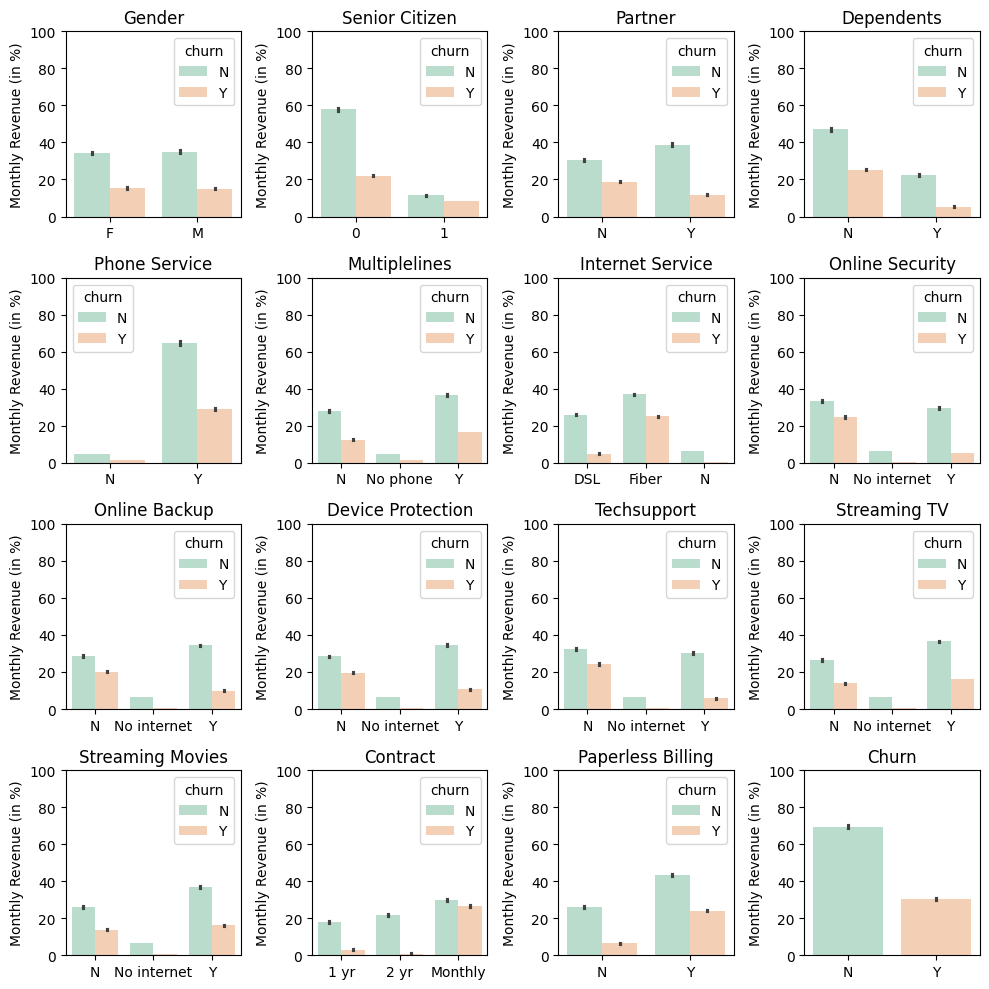

In [45]:
## Adding new column to the dataframe temporarily
# When the dataframe is grouped later, the estimator in `barplot`
# will give groupwise revenue share
df['share'] = (df['monthlycharges'] * 100) / df['monthlycharges'].sum()

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
titles = ['Gender', 'Senior Citizen', 'Partner', 'Dependents',
          'Phone Service', 'Multiplelines', 'Internet Service', 'Online Security',
          'Online Backup', 'Device Protection', 'Techsupport', 'Streaming TV',
          'Streaming Movies', 'Contract', 'Paperless Billing', 'Churn']

## axs.flat is an attribute and contains a flattened axs vector/ list
ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.barplot(x=''.join(title.lower().split()), y='share', hue='churn', data=df,
                estimator=np.sum, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('Monthly Revenue (in %)')

fig.tight_layout()

***Inference:*** We can say that majority of the churned customers are not senior citizens, have dependents, are subscribed to phone service, Fiber internet, and paperless billing, are not subscribed to online security and tech support, and have monthly contracts.

In [46]:
## Remove the 'share' column
df.drop(labels=['share'], axis=1, inplace=True)

<a id="churn-among-phone-service%2C-multiple-lines%2C-and-internet-service"></a>
## 3.7.  Churn among phone service, multiple lines, and internet service
Modifying seaborn countplot make it work with FacetGrid when all 3 arguments (`hue`, `row`, and `col`) are used.

In [48]:
def modified_countplot(**kargs):
    """
        Assumes that columns to be plotted are in of pandas dtype='CategoricalDtype'
    """
    facet_gen = kargs['facet_generator']    ## Facet generator over facet data
    curr_facet, facet_data = None, None
    
    while True:
        ## Keep yielding until non-empty dataframe is found
        curr_facet = next(facet_gen)            ## Yielding facet genenrator
        df_rows = curr_facet[1].shape[0]
        
        ## Skip the current facet if its corresponding dataframe empty
        if df_rows:
            facet_data = curr_facet[1]
            break
    
    x_hue = (kargs.get('x'), kargs.get('hue'))
    cols = [col for col in x_hue if col]
    col_categories = [facet_data[col].dtype.categories if col else None for col in x_hue]
    
    palette = kargs['palette'] if 'palette' in kargs.keys() else 'Pastel2'
    sns.countplot(x=cols[0], hue=x_hue[1], 
                  order=col_categories[0], hue_order=col_categories[1],
                  data=facet_data.loc[:, cols], palette=palette)

phoneservice      N                                            Y              \
multiplelines     N          No phone            Y             N               
internetservice DSL Fiber  N      DSL Fiber  N DSL Fiber  N  DSL Fiber     N   
churn                                                                          
N                 0     0  0      510     0  0   0     0  0  831   628  1077   
Y                 0     0  0      170     0  0   0     0  0  216   530   103   

phoneservice                                       
multiplelines   No phone             Y             
internetservice      DSL Fiber  N  DSL Fiber    N  
churn                                              
N                      0     0  0  616  1171  330  
Y                      0     0  0   73   767   10

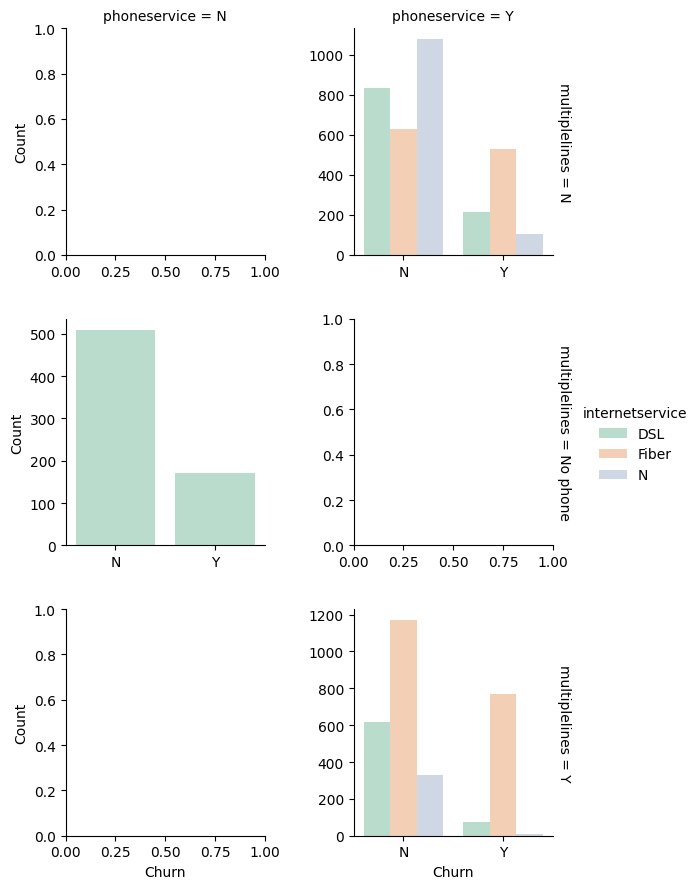

In [49]:
## phone service, multiple lines, internet service
display(pd.crosstab(df['churn'], [df['phoneservice'], df['multiplelines'], df['internetservice']], dropna=False))

## PLOT
facet = sns.FacetGrid(df, row='multiplelines', col='phoneservice',
                      sharex=False, sharey=False, margin_titles=True)
facet.map(modified_countplot, x='churn', hue='internetservice',
          palette='Pastel2', facet_generator=facet.facet_data())
facet.set_xlabels('Churn')
facet.set_ylabels('Count')
facet.add_legend(title='internetservice');

<a id="churn-among-phone-service%2C-internet-service%2C-and-seniorcitizen"></a>
## 3.8.  Churn among phone service, internet service, and seniorcitizen

phoneservice       N                           Y                           
seniorcitizen      0            1              0                1          
internetservice  DSL Fiber  N DSL Fiber  N   DSL Fiber     N  DSL Fiber   N
churn                                                                      
N                450     0  0  60     0  0  1326  1361  1360  121   438  47
Y                126     0  0  44     0  0   255   904   108   34   393   5

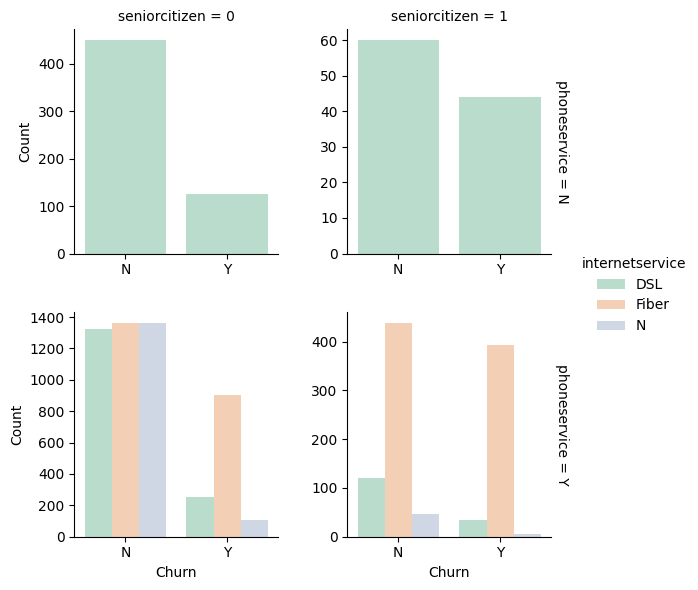

In [50]:
## phone service, internet service, seniorcitizen
crosstab_cols = [df['phoneservice'], df['seniorcitizen'], df['internetservice']]
display(pd.crosstab(df['churn'], crosstab_cols, dropna=False))

## PLOT
facet = sns.FacetGrid(df, row='phoneservice', col='seniorcitizen', 
                      sharex=False, sharey=False, margin_titles=True)
facet.map(modified_countplot, x='churn', hue='internetservice', 
          palette='Pastel2', facet_generator=facet.facet_data())
facet.set_xlabels('Churn')
facet.set_ylabels('Count')
facet.add_legend(title='internetservice');

<a id="churn-among-phone-service%2C-internet-service%2C-and-gender"></a>
## 3.9.  Churn among phone service, internet service, and gender

phoneservice       N                           Y                           
gender             F             M             F               M           
internetservice  DSL Fiber  N  DSL Fiber  N  DSL Fiber    N  DSL Fiber    N
churn                                                                      
N                249     0  0  261     0  0  716   889  690  731   910  717
Y                 80     0  0   90     0  0  139   664   56  150   633   57

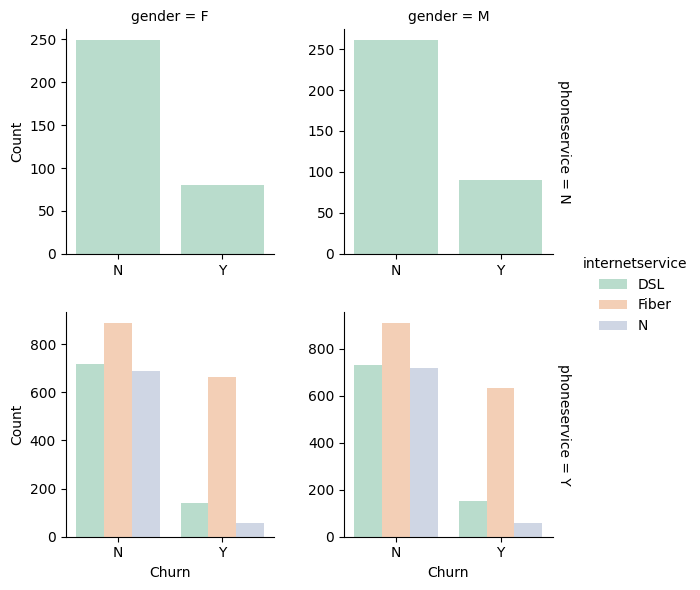

In [51]:
## phone service, internet service, gender
crosstab_cols = [df['phoneservice'], df['gender'], df['internetservice']]
display(pd.crosstab(df['churn'], crosstab_cols, dropna=False))

## PLOT
facet = sns.FacetGrid(df, row='phoneservice', col='gender', 
                      sharex=False, sharey=False, margin_titles=True)
facet.map(modified_countplot, x='churn', hue='internetservice',
          palette='Pastel2', facet_generator=facet.facet_data())
facet.set_xlabels('Churn')
facet.set_ylabels('Count')
facet.add_legend(title='internetservice');

<a id="churn-among-internet-service%2C-streamingtv%2C-and-streamingmovies"></a>
## 3.10.  Churn among internet service, streamingtv, and streamingmovies

internetservice     Y                     N         
streamingtv         N         Y           N     Y   
streamingmovies     N    Y    N     Y     N  Y  N  Y
churn                                               
N                1322  545  521  1368  1407  0  0  0
Y                 695  247  243   571   113  0  0  0

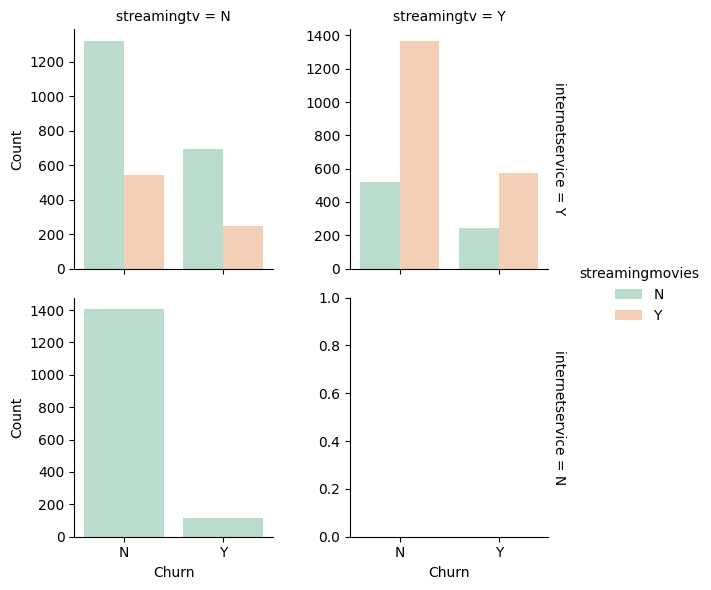

In [52]:
## internet service, streamingtv, streamingmovies
# Remap values
## Having 'DSL' or 'Fiber' internet implies having internet
value_mapper = {'internetservice':  {'Fiber': 'Y', 'DSL': 'Y', 
                                     'No internet': 'N'},
                'streamingtv': {'No internet': 'N'},
                'streamingmovies': {'No internet': 'N'}}
df_modified = df.replace(to_replace=value_mapper)
df_modified = to_categorical(list(value_mapper.keys()), df_modified)

display(pd.crosstab(df_modified['churn'], 
                    [df_modified['internetservice'], 
                     df_modified['streamingtv'], 
                     df_modified['streamingmovies']], 
                    dropna=False))

## PLOT
facet = sns.FacetGrid(df_modified, row='internetservice', col='streamingtv', 
                      sharey=False, margin_titles=True)
facet_data = facet.facet_data()
facet.map(modified_countplot, x='churn', hue='streamingmovies', 
          palette='Pastel2', facet_generator=facet_data)
facet.set_xlabels('Churn')
facet.set_ylabels('Count')
facet.add_legend(title='streamingmovies');

<a id="churn-among-contract-and-internet-service"></a>
## 3.11.  Churn among contract and internet service

contract        1 yr            2 yr            Monthly           
internetservice  DSL Fiber    N  DSL Fiber    N     DSL Fiber    N
churn                                                             
N                517   435  354  611   398  628     829   966  425
Y                 53   104    9   12    31    5     394  1162   99

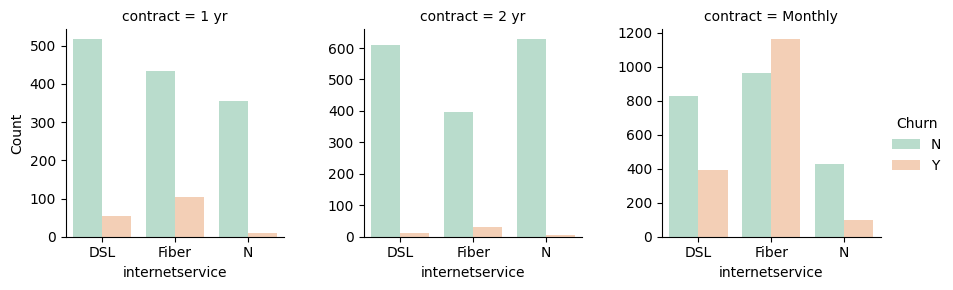

In [53]:
## phone service, multiple lines, internet service
display(pd.crosstab(df['churn'], [df['contract'], df['internetservice']], dropna=False))

## PLOT
facet = sns.FacetGrid(df, col='contract',sharex=False, sharey=False)
facet.map(modified_countplot, x='internetservice', hue='churn',
          palette='Pastel2', facet_generator=facet.facet_data())
facet.set_xlabels('internetservice')
facet.set_ylabels('Count')
facet.add_legend(title='Churn');

<a id="data-preprocessing"></a>
# 4.  Data Preprocessing
Data needs to be one-hot-encoded before applying machine learning models.

In [72]:
x = df.iloc[:, :-1]
y = df['churn']

categorical_columns = list(x.select_dtypes(include='category').columns)
numeric_columns = list(x.select_dtypes(exclude='category').columns)

<a id="train-test-split"></a>
## 4.1.  Train-Test split
CatBoost classifier does not require any knd of preprocessing while Naive bayes requires a different kind of preprocesing. Therefore, we will use raw/ unmodified data (`x_train_cat, x_test_cat, y_train_cat, y_test_cat`) for CatBoost and preprocessed data (`x_train, x_test, y_train, y_test`) for all other classifiers. For Naive Bayes, we will use the raw data (`x_train_cat, x_test_cat, y_train_cat, y_test_cat`) and preprocess it as required in the Naive Bayes section.

In [73]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.25, random_state=0,
                               shuffle=True, stratify=y)
x_train, x_test, y_train, y_test = data_splits


# For CatBoost and Naive Bayes
data_splits = train_test_split(x, y, test_size=0.25, random_state=0,
                               shuffle=True, stratify=y)
x_train_cat, x_test_cat, y_train_cat, y_test_cat = data_splits


# Save the non-scaled version of monthlycharges and totalcharges to compare classifiers
x_test_charges = np.array(x_test[['monthlycharges', 'totalcharges']], copy=True)

list(map(lambda x: x.shape, [x, y, x_train, x_test, y_train, y_test]))

[(7032, 19), (7032,), (5274, 19), (1758, 19), (5274,), (1758,)]

In [107]:
x_train_cat

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,tenure,monthlycharges,totalcharges
1720,F,1,N,N,Y,N,Fiber,N,Y,N,N,Y,N,Monthly,Y,Bank transfer,2,83.80,163.70
6657,F,0,Y,N,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,1 yr,N,Bank transfer,49,20.45,900.90
4957,M,0,N,N,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,Monthly,Y,Electronic check,13,20.40,251.65
4681,M,1,N,N,Y,Y,Fiber,N,N,N,N,N,Y,Monthly,Y,Electronic check,9,83.85,790.15
3509,M,0,N,N,Y,N,DSL,N,N,N,N,N,N,Monthly,Y,Mailed check,1,44.90,44.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,M,1,N,N,Y,Y,Fiber,N,Y,Y,N,Y,Y,Monthly,Y,Electronic check,23,106.40,2483.50
2608,M,0,Y,Y,N,No phone,DSL,Y,N,N,Y,N,N,Monthly,Y,Electronic check,7,34.50,279.25
3963,F,0,N,N,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Credit card,68,19.60,1441.65
6139,M,0,N,Y,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,Monthly,N,Bank transfer,3,20.20,50.60


In [56]:
pd.Series(y_test).value_counts()

churn
N    1291
Y     467
Name: count, dtype: int64

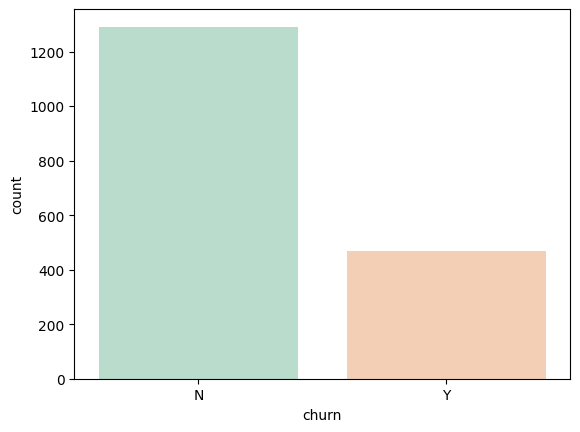

In [58]:
sns.countplot(x=y_test,palette='Pastel2');

<a id="one-hot-encoding-and-standardization"></a>
## 4.2.  One-hot Encoding and Standardization
We need to standardize the continuous or quantitative variables/ features before applying Machine Learning models. This is important because if we don't standardize the features, features with high variance that are orders of magnitude larger that others might dominate the model fitting process and causing the model unable to learn from other features (with lower variance) correctly as expected. <br/>
There is no need to standardize categorical variables.

***Also we need to standardize the data only after performing train-test split because if we standardize before splitting then there is a chance for some information leak from the test set into the train set. We always want the test set to be completely new to the ML models. [Read more](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data)***

In [65]:
list(x.select_dtypes(include='category').columns)

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

categorical_columns = list(x.select_dtypes(include='category').columns)


## Column Transformer
transformers = [('one_hot_encoder',OneHotEncoder(drop='first',dtype='int'),categorical_columns),
                ('standard_scaler', StandardScaler(), numeric_columns)]
x_trans = ColumnTransformer(transformers, remainder='passthrough')

## Applying Column Transformer
x_train = x_trans.fit_transform(x_train)     #converts to numpy array
x_test = x_trans.transform(x_test)          #converts to numpy array

## Label encoding
y_trans = LabelEncoder()
y_train = y_trans.fit_transform(y_train)
y_test = y_trans.transform(y_test)


## Save feature names after one-hot encoding for feature importances plots
feature_names = list(x_trans.named_transformers_['one_hot_encoder'] \
                            .get_feature_names_out(input_features=categorical_columns))
feature_names = feature_names + numeric_columns

<a id="data-modeling"></a>
# 5.  Data Modeling
Since the dataset is imbalanced we will be using class-weighted/ cost-sensitive learning. In cost-sensitive learning, a weighted cost function is used. Therefore, misclassifying a sample from the minority class will cost the classifiers more than misclassifying a sample from the majority class. In most of the Sklearn classifiers, cost-sensitive learning can be enabled by setting `class_weight='balanced'`.

<a id="utility-functions"></a>
## 5.1.  Utility Functions

In [80]:
import timeit
import pickle
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError

In [81]:
def confusion_plot(matrix, labels=None):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()
    
    return fig

In [82]:
def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs, drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

In [90]:
def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    p, r, thresh = list(p), list(r), list(thresh)
    p.pop()
    r.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(x=r, y=p, ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(x=thresh, y=p, label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(x=thresh, y=r, color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

In [84]:
def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance Measures')
    
    plt.close()
    
    return axis if ax else fig

In [85]:
def train_clf(clf, x_train, y_train, sample_weight=None, refit=False):
    train_time = 0
    
    try:
        if refit:
            raise NotFittedError
        y_pred_train = clf.predict(x_train)
    except NotFittedError:
        start = timeit.default_timer()
        
        if sample_weight is not None:
            clf.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            clf.fit(x_train, y_train)
        
        end = timeit.default_timer()
        train_time = end - start
        
        y_pred_train = clf.predict(x_train)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    return clf, y_pred_train, train_acc, train_time

In [86]:
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

In [87]:
def report(clf, x_train, y_train, x_test, y_test, sample_weight=None,
           refit=False, importance_plot=False, confusion_labels=None,
           feature_labels=None, verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    ## Train if not already trained
    clf, train_predictions, \
    train_acc, train_time = train_clf(clf, x_train, y_train,
                                                     sample_weight=sample_weight,
                                                     refit=refit)
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    end = timeit.default_timer()
    test_time = end - start
    
    test_acc = accuracy_score(y_test, test_predictions)
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probs)
    
    
    ## Model Memory
    model_mem = round(model_memory_size(clf) / 1024, 2)
    
    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("------------------------------------------")
    print(f"Training Time: {round(train_time, 3)} seconds")
    print(f" Testing Time: {round(test_time, 3)} seconds")
    print("------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("------------------------------------------")
    print(" Area Under ROC: ", roc_auc)
    print("------------------------------------------")
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    
    
    if verbose:
        print("\n================================> CONFUSION MATRIX <=====================================")
    
        ## Confusion Matrix HeatMap
        display(confusion_plot(confusion_matrix(y_test, test_predictions),
                               labels=confusion_labels))
        print("\n=======================================> PLOTS <=========================================")


        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
                importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()


        ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    
    ## Dump to report_dict
    dump = dict(clf=clf, train_acc=train_acc, train_time=train_time,
                train_predictions=train_predictions, test_acc=test_acc,
                test_time=test_time, test_predictions=test_predictions,
                test_probs=y_probs, report=clf_rep, roc_auc=roc_auc,
                model_memory=model_mem)
    
    return clf, dump

In [91]:
def compare_models(y_test=None, clf_reports=[], labels=[]):
    """ Compare evaluation metrics for the True Positive class [1] of 
        binary classifiers passed in the argument and plot ROC and PR curves.
        
        Arguments:
        ---------
        y_test: to plot ROC and Precision-Recall curves
        
        Returns:
        -------
        compare_table: pandas DataFrame containing evaluated metrics
                  fig: `matplotlib` figure object with ROC and PR curves """

    
    ## Classifier Labels
    default_names = [rep['clf'].__class__.__name__ for rep in clf_reports]
    clf_names =  labels if len(labels) == len(clf_reports) else default_names
    
    
    ## Compare Table
    table = dict()
    index = ['Train Accuracy', 'Test Accuracy', 'Overfitting', 'ROC Area',
             'Precision', 'Recall', 'F1-score', 'Support']
    for i in range(len(clf_reports)):
        train_acc = round(clf_reports[i]['train_acc'], 3)
        test_acc = round(clf_reports[i]['test_acc'], 3)
        clf_probs = clf_reports[i]['test_probs']
        roc_auc = clf_reports[i]['roc_auc']
        
        # Get metrics of True Positive class from sklearn classification_report
        true_positive_metrics = list(clf_reports[i]['report']["1"].values())
        
        table[clf_names[i]] = [train_acc, test_acc,
                               test_acc < train_acc, roc_auc] + true_positive_metrics
    
    table = pd.DataFrame(data=table, index=index)
    
    
    ## Compare Plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # ROC and Precision-Recall
    for i in range(len(clf_reports)):
        clf_probs = clf_reports[i]['test_probs']
        roc_plot(y_test, clf_probs, label=clf_names[i],
                 compare=True, ax=axes[0])
        precision_recall_plot(y_test, clf_probs, label=clf_names[i],
                              compare=True, ax=axes[1])
    # Plot No-Info classifier
    axes[0].plot([0,1], [0,1], linestyle='--', color='green')
        
    fig.tight_layout()
    plt.close()
    
    return table.T, fig

<a id="naive-bayes"></a>
## 5.2.  Naive Bayes
The fundamental assumption made by Naive Bayes regarding the data is ***class conditional independence of features***. Sklearn provides different variants of Naive Bayes depending on whether the features follow a categorical distribution (CategoricalNB), normal distribution (GaussianNB), bernoulli distribution (BernoulliNB), multinomial distribution (MultinomialNB).

Since majority of the features are categorical and follow a categorical distribution, we will use CategoricalNB. Continuous features will be discretized.

CategoricalNB()

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 0.006 seconds
 Testing Time: 0.002 seconds
------------------------------------------
Train Accuracy:  0.7387182404247251
 Test Accuracy:  0.7377701934015927
------------------------------------------
 Area Under ROC:  0.8212439272379859
------------------------------------------
Model Memory Size: 5.77 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1291
       Churn       0.50      0.79      0.62       467

    accuracy                           0.74      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.80      0.74      0.75      1758


================================> CONFUSION MATRIX <======

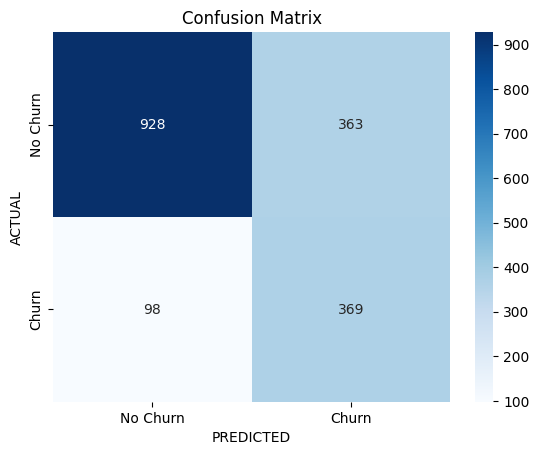


=======================================> PLOTS <=========================================


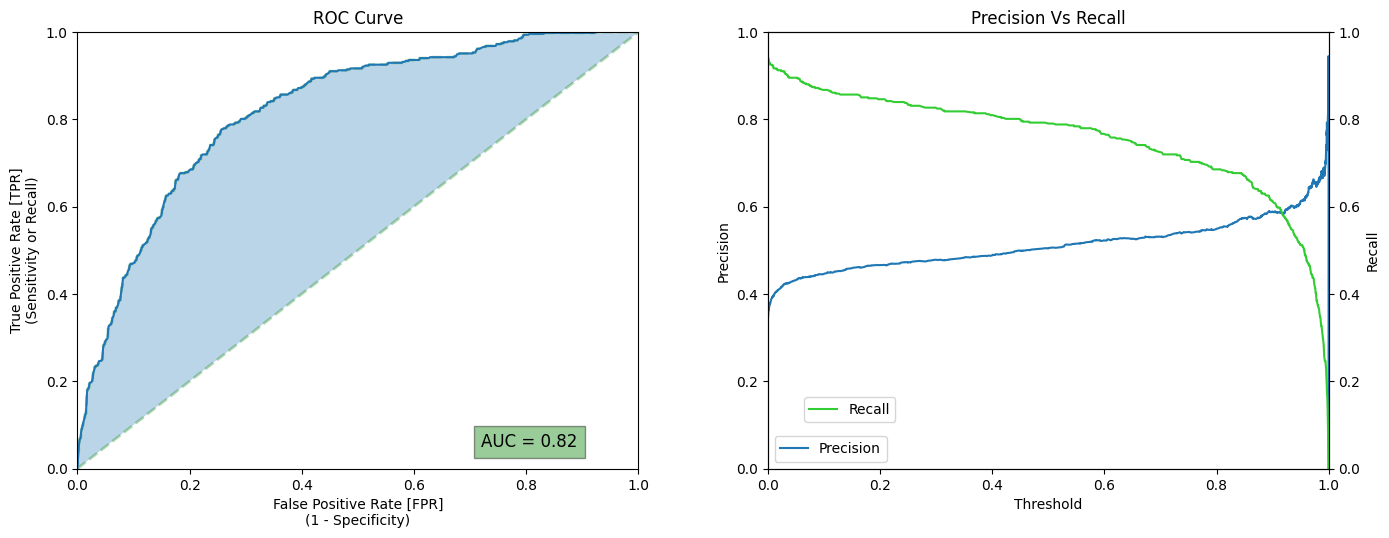

In [92]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB 
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder

confusion_lbs = ['No Churn', 'Churn']

## Discretize 'monthlycharges' and 'totalcharges' into 3bins
kbn = KBinsDiscretizer(n_bins=3, encode='ordinal')
ode = OrdinalEncoder(dtype=np.int64)
nb_trans = [('ordinal', ode, categorical_columns),
            ('kbn', kbn, numeric_columns[1:])]
nb_col_trans = ColumnTransformer(nb_trans, remainder='passthrough')

## Applying Column Transformer
x_train_nb = nb_col_trans.fit_transform(x_train_cat)
x_test_nb = nb_col_trans.transform(x_test_cat)

nb_clf = CategoricalNB()

nb_clf, nb_report = report(nb_clf, x_train_nb, y_train,
                           x_test_nb, y_test, refit=True,
                           confusion_labels=confusion_lbs)

<a id="logistic-regression"></a>
## 5.3.  Logistic Regression

LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=500, n_jobs=-1,
                     penalty='l1', random_state=0, scoring='f1',
                     solver='liblinear')

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 4.324 seconds
 Testing Time: 0.0 seconds
------------------------------------------
Train Accuracy:  0.7510428517254456
 Test Accuracy:  0.7514220705346986
------------------------------------------
 Area Under ROC:  0.844624371990572
------------------------------------------
Model Memory Size: 14.16 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.81      1291
       Churn       0.52      0.78      0.63       467

    accuracy                           0.75      1758
   

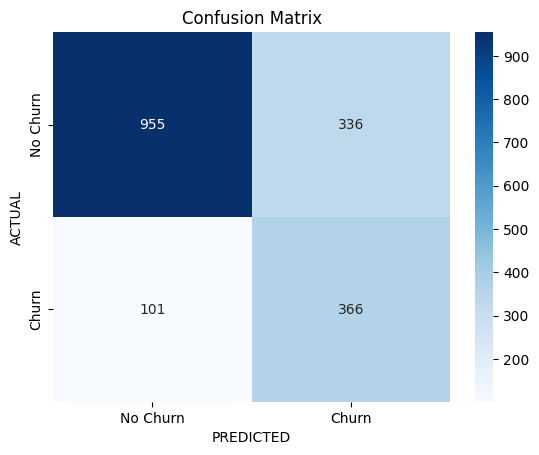


=======================================> PLOTS <=========================================


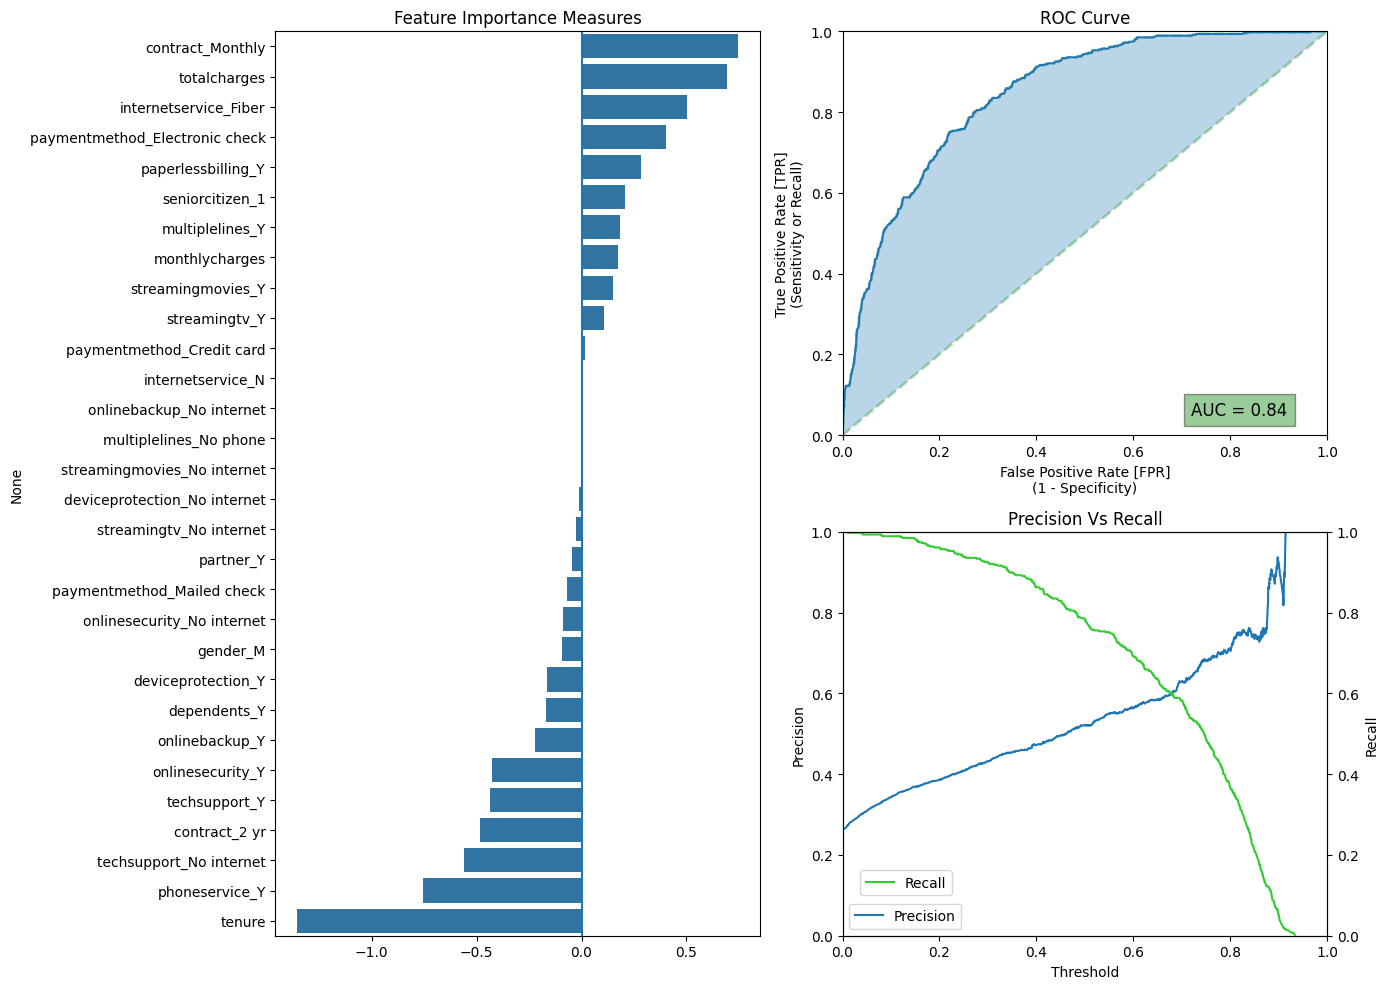

In [93]:
from sklearn.linear_model import LogisticRegressionCV

logit_cv = LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=500,
                                scoring='f1', penalty='l1', solver='liblinear',
                                n_jobs=-1, random_state=0, refit=True, verbose=0)

logit_cv, logit_report = report(logit_cv, x_train, y_train,
                                x_test, y_test, refit=True,
                                importance_plot=True,
                                feature_labels=feature_names,
                                confusion_labels=confusion_lbs)

<a id="k-nearest-neighbors"></a>
## 5.4.  K-Nearest Neighbors
KNN estimator in Scikit-learn does not provide a way to pass class-weights to enable cost-sensitive/ class-weighted learning.

KNeighborsClassifier(n_jobs=-1, n_neighbors=91, p=1)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 0.003 seconds
 Testing Time: 0.064 seconds
------------------------------------------
Train Accuracy:  0.7999620781190747
 Test Accuracy:  0.7969283276450512
------------------------------------------
 Area Under ROC:  0.8429383460193035
------------------------------------------
Model Memory Size: 1277.99 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

    No Churn       0.85      0.88      0.86      1291
       Churn       0.63      0.57      0.60       467

    accuracy                           0.80      1758
   macro avg       0.74      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758


==================

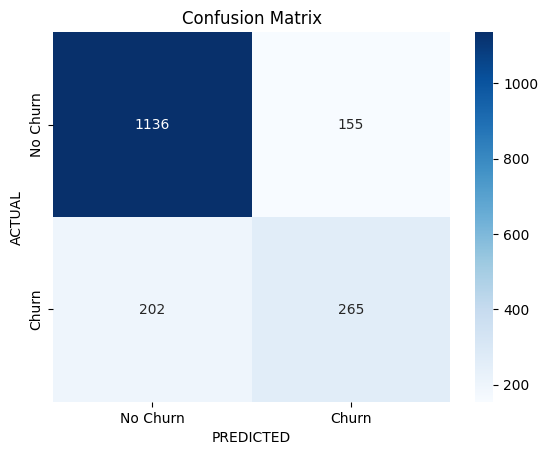


=======================================> PLOTS <=========================================


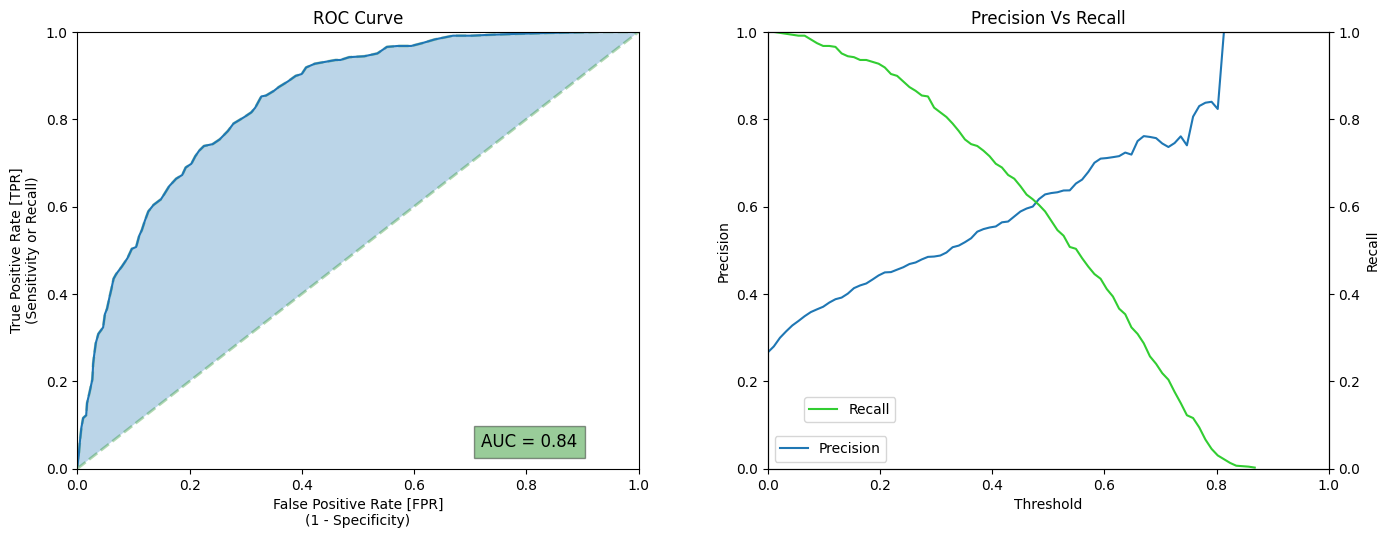

In [94]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=91, p=1,
                           weights='uniform', n_jobs=-1)

knn, knn_report = report(knn, x_train, y_train,
                         x_test, y_test,
                         importance_plot=True,
                         feature_labels=feature_names,
                         confusion_labels=confusion_lbs)

<a id="decision-tree"></a>
## 5.5.  Decision Tree

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 0.017 seconds
 Testing Time: 0.0 seconds
------------------------------------------
Train Accuracy:  0.7533181645809632
 Test Accuracy:  0.7502844141069397
------------------------------------------
 Area Under ROC:  0.8176902522321391
------------------------------------------
Model Memory Size: 2.33 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

    No Churn       0.89      0.75      0.82      1291
       Churn       0.52      0.74      0.61       467

    accuracy                           0.75      1758
   macro avg       0.71      0.75      0.71      1758
weighted av

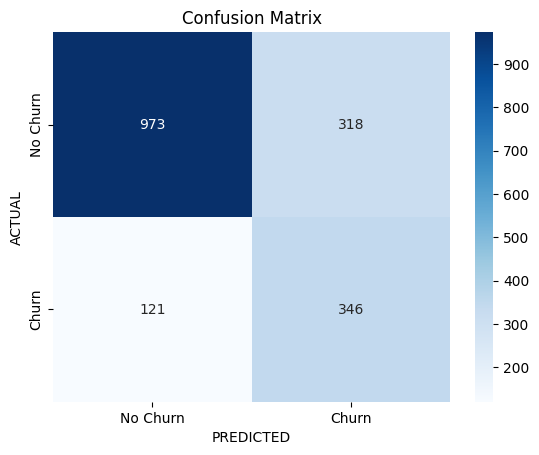


=======================================> PLOTS <=========================================


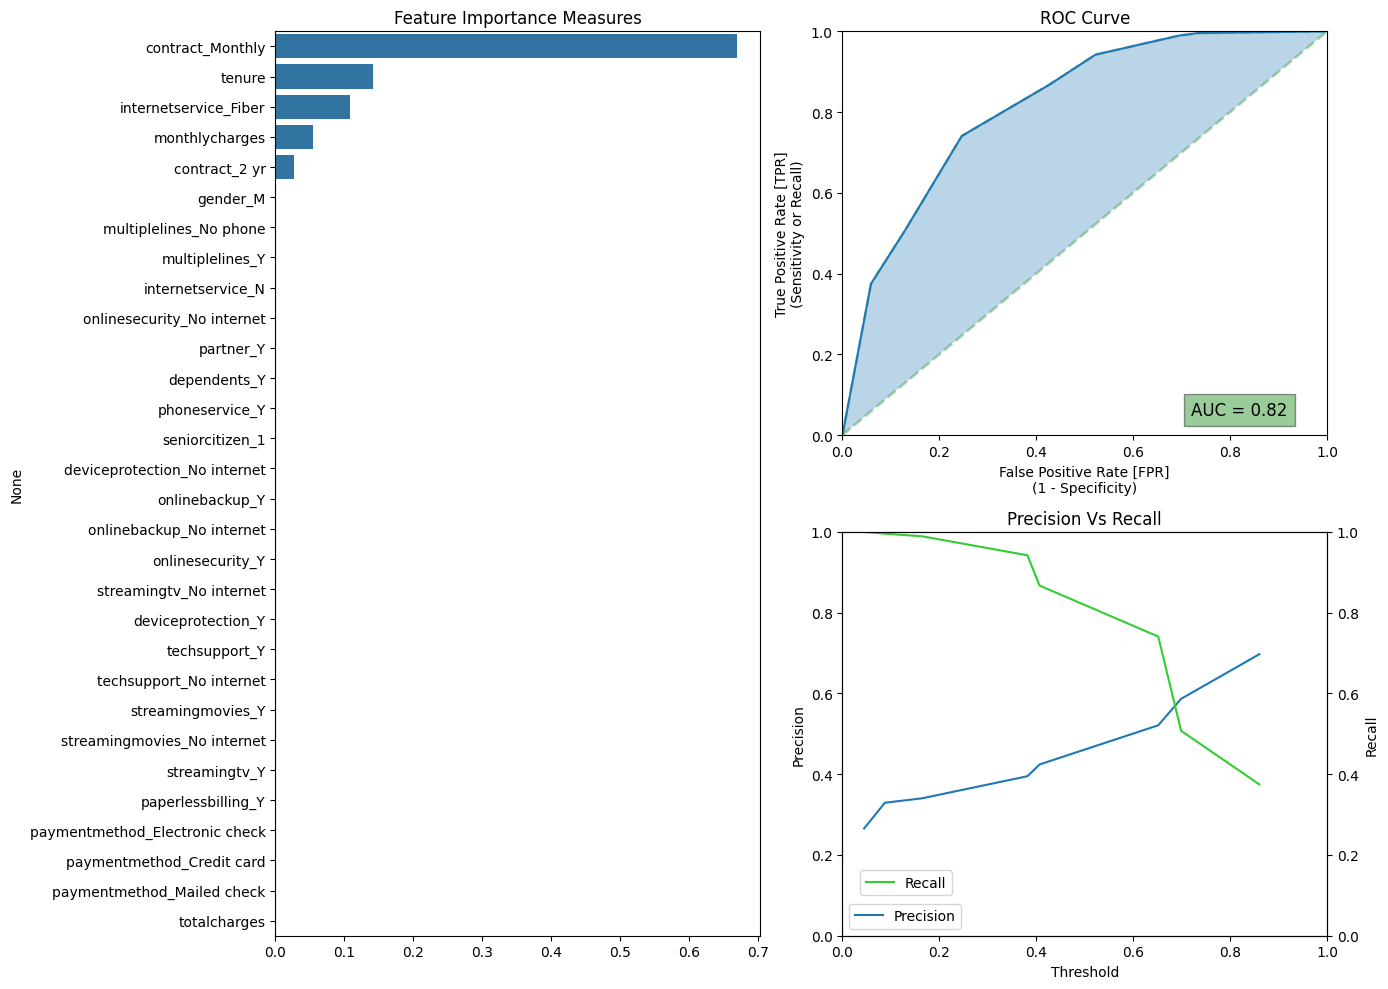

In [95]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy',
                                       max_depth=3,
                                       random_state=0)

decision_tree, decision_tree_report = report(decision_tree, x_train, y_train,
                                             x_test, y_test,
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

<a id="decision-trees-with-bagging"></a>
## 5.6.  Decision Trees with Bagging

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   criterion='entropy',
                                                   max_depth=2,
                                                   random_state=0),
                  max_features=15, max_samples=110, n_estimators=80, n_jobs=-1,
                  random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 2.246 seconds
 Testing Time: 0.044 seconds
------------------------------------------
Train Accuracy:  0.748388320060675
 Test Accuracy:  0.7434584755403868
------------------------------------------
 Area Under ROC:  0.8372333914416559
------------------------------------------
Model Memory Size: 86.94 kB

=============================> CLASSIFICATION REPORT <===================================
        

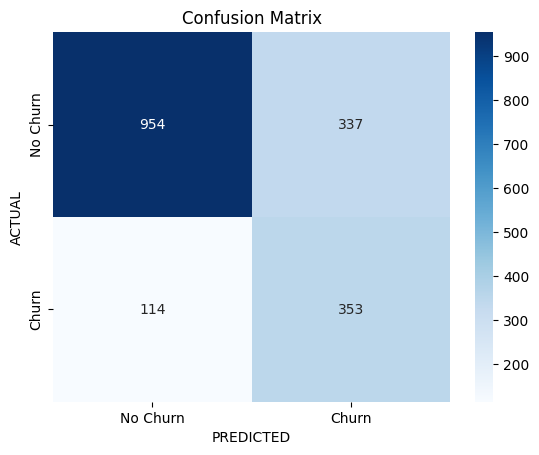


=======================================> PLOTS <=========================================


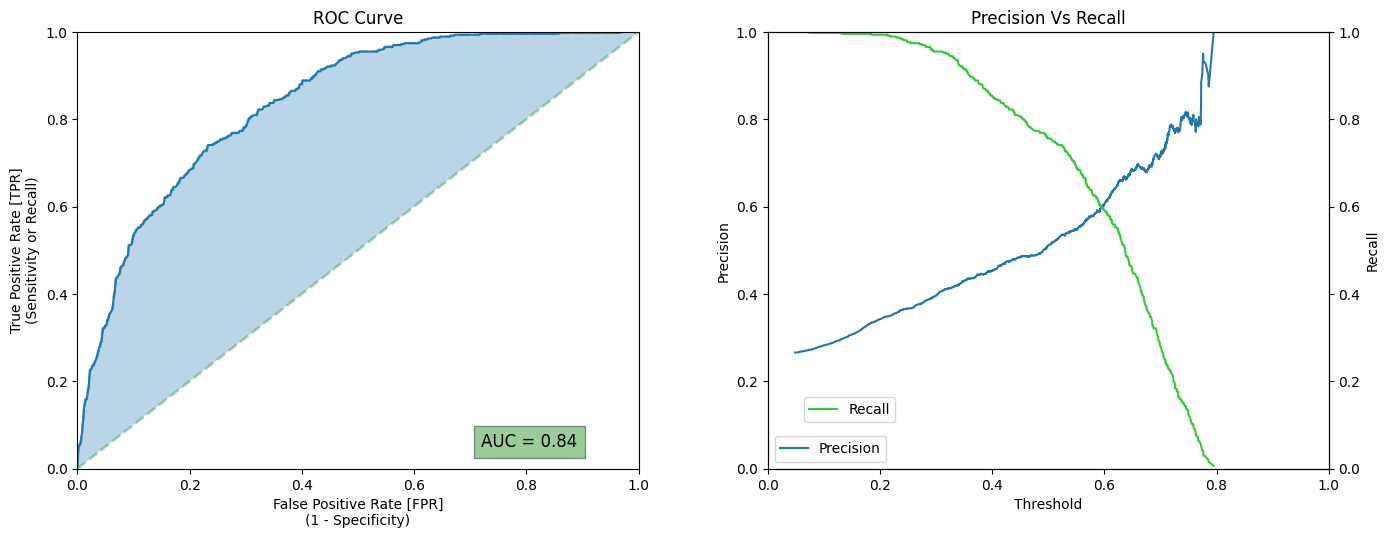

In [97]:
from sklearn.ensemble import BaggingClassifier

bagging_dtree = DecisionTreeClassifier(max_depth=2, class_weight='balanced',
                                       criterion='entropy', random_state=0)

bagging_clf = BaggingClassifier(estimator=bagging_dtree,
                                max_samples=110, n_estimators=80,
                                max_features=15, n_jobs=-1,
                                random_state=0)

bagging_clf, bagging_clf_report = report(bagging_clf, x_train, y_train,
                                         x_test, y_test,
                                         feature_labels=feature_names,
                                         confusion_labels=confusion_lbs)

<a id="random-forests"></a>
## 5.7.  Random Forests

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, n_jobs=-1, random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 0.275 seconds
 Testing Time: 0.051 seconds
------------------------------------------
Train Accuracy:  0.6996587030716723
 Test Accuracy:  0.7002275312855518
------------------------------------------
 Area Under ROC:  0.8339616883149193
------------------------------------------
Model Memory Size: 54.01 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

    No Churn       0.91      0.66      0.76      1291
       Churn       0.46      0.82      0.59       467

    accuracy                           0.70      1758
   macro avg       0.69      0.74      0.68      17

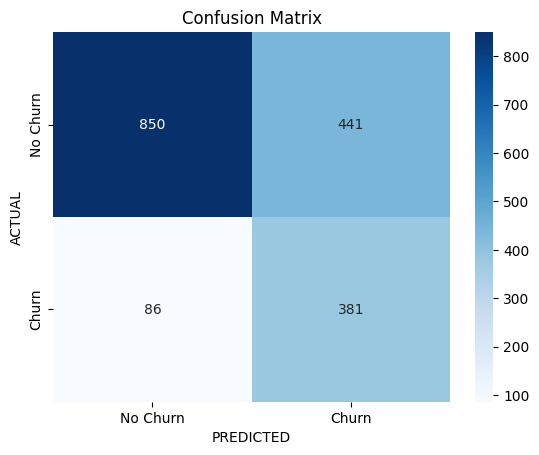


=======================================> PLOTS <=========================================


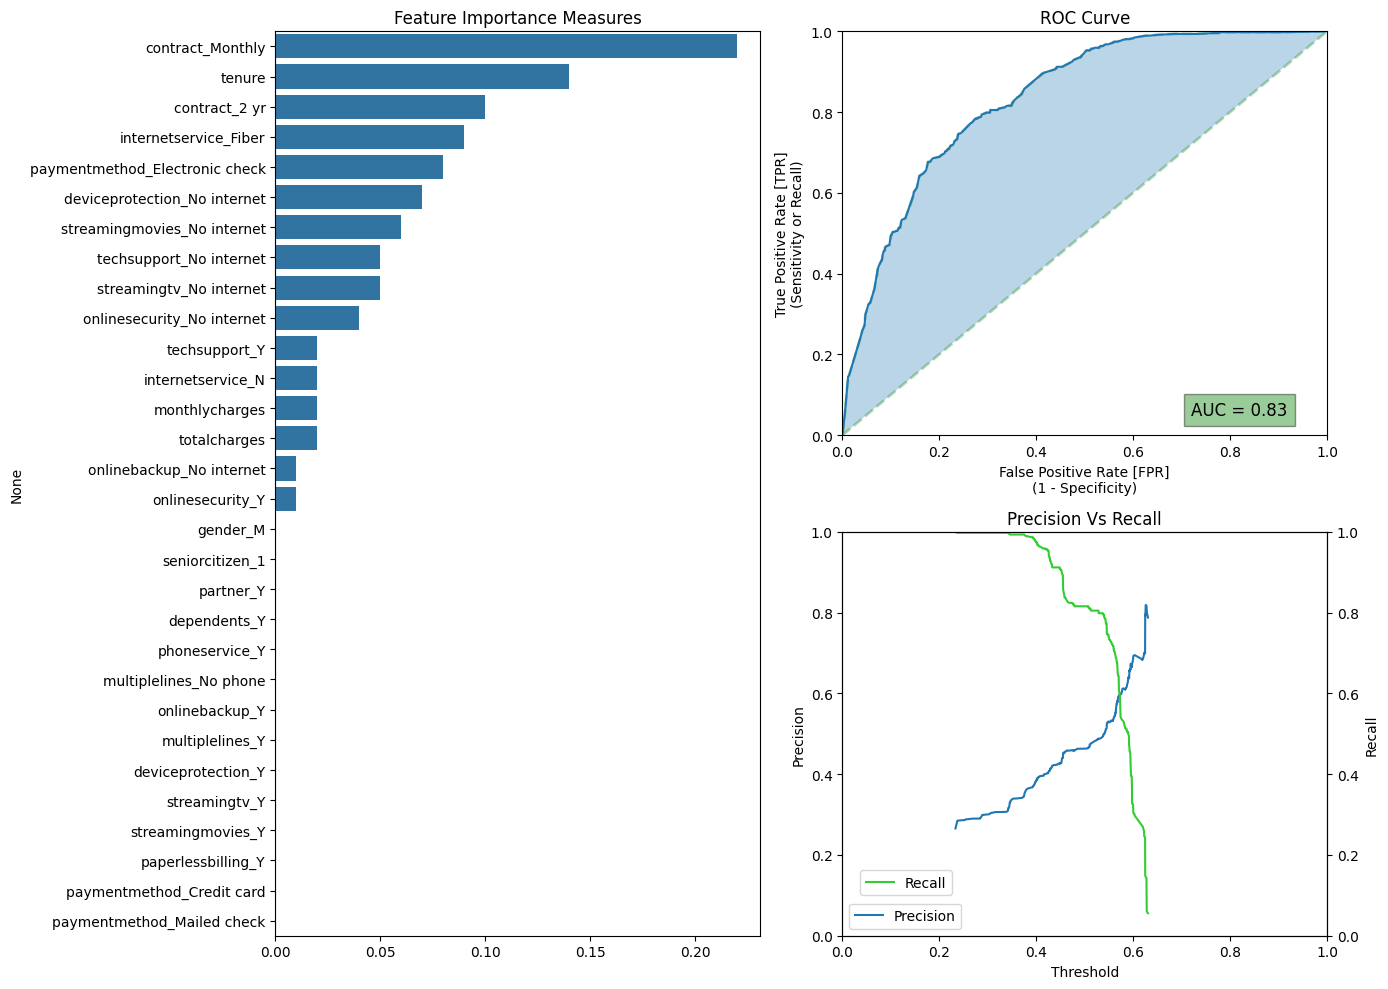

In [98]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                                       max_depth=1, n_estimators=100,
                                       n_jobs=-1, random_state=0)

random_forest, random_forest_report = report(random_forest, x_train, y_train,
                                             x_test, y_test,
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

<a id="decision-trees-with-adaboost"></a>
## 5.8.  Decision Trees with AdaBoost
The default base estimator for `AdaBoostClassifier` is `DecisionTreeClassifier(max_depth=1)`

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=1,
                                                    random_state=0),
                   learning_rate=0.1, n_estimators=285, random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 2.527 seconds
 Testing Time: 0.071 seconds
------------------------------------------
Train Accuracy:  0.748767538869928
 Test Accuracy:  0.7457337883959044
------------------------------------------
 Area Under ROC:  0.8477244040026737
------------------------------------------
Model Memory Size: 155.75 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score  

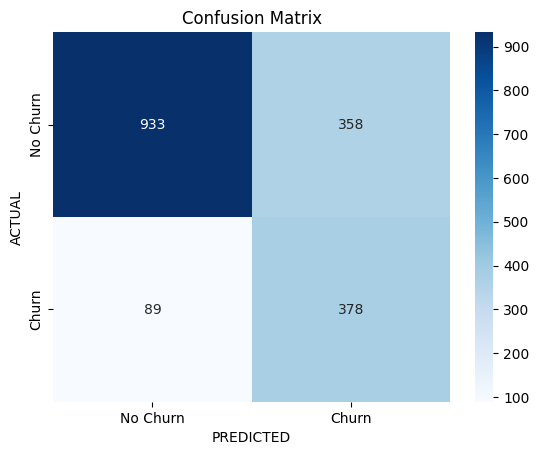


=======================================> PLOTS <=========================================


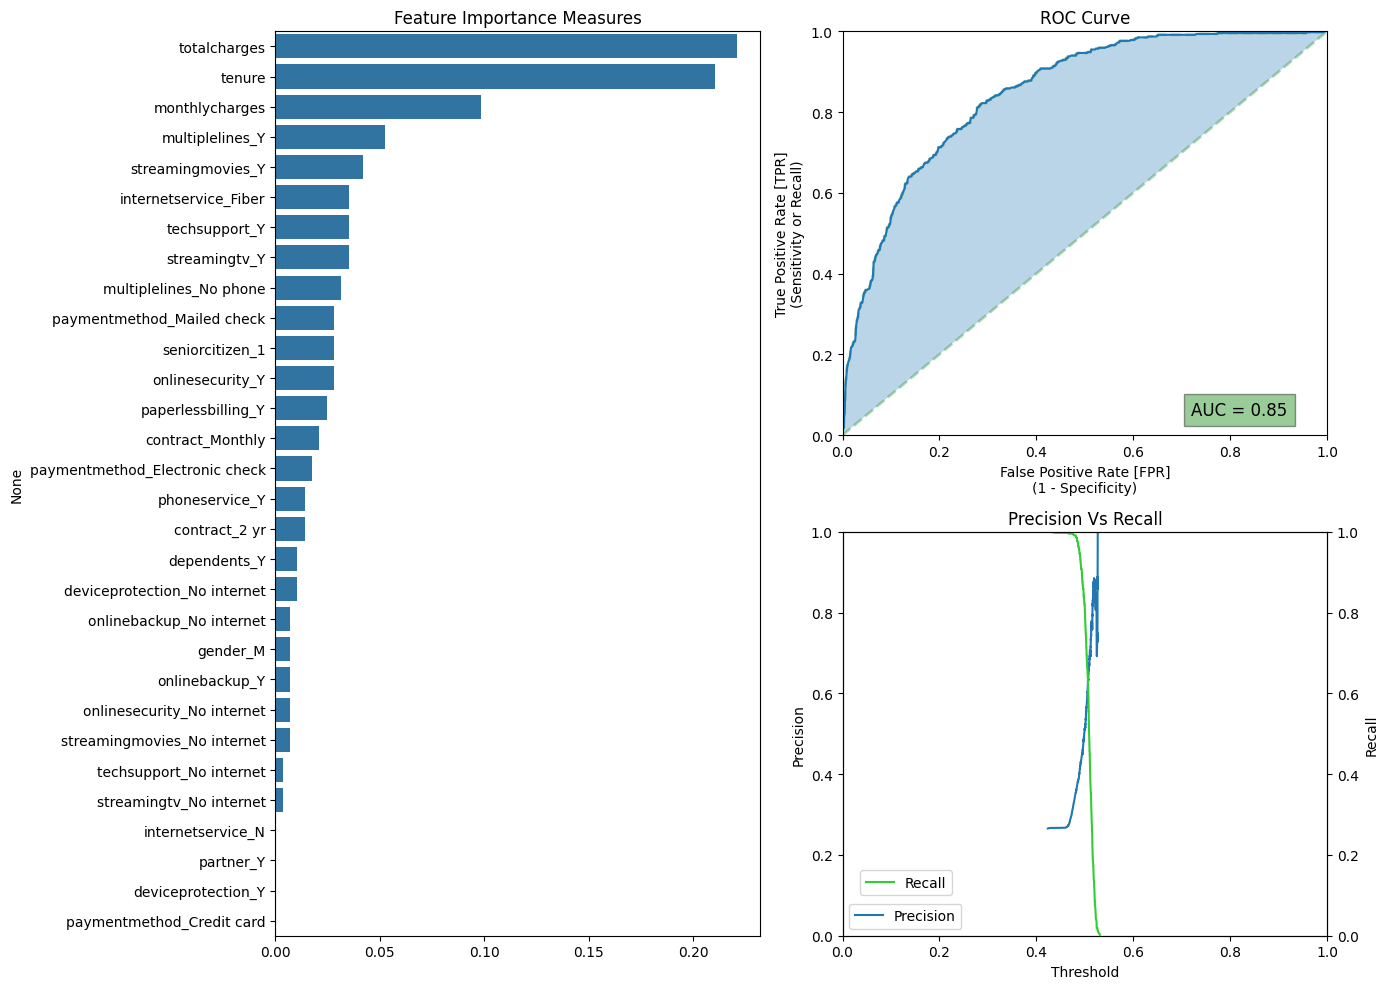

In [99]:
from sklearn.ensemble import AdaBoostClassifier

boosting_dtree = DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_depth=1, random_state=0)
adaboot = AdaBoostClassifier(estimator=boosting_dtree,
                             n_estimators=285, learning_rate=0.1,
                             random_state=0)

adaboot, adaboot_report = report(adaboot, x_train, y_train,
                                 x_test, y_test,
                                 importance_plot=True,
                                 feature_labels=feature_names,
                                 confusion_labels=confusion_lbs)

<a id="linear-svc"></a>
## 5.9.  Linear SVC

SVC(class_weight='balanced', kernel='linear', probability=True, random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 4.377 seconds
 Testing Time: 0.135 seconds
------------------------------------------
Train Accuracy:  0.7000379218809253
 Test Accuracy:  0.7007963594994312
------------------------------------------
 Area Under ROC:  0.8324465041292294
------------------------------------------
Model Memory Size: 751.57 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

    No Churn       0.91      0.66      0.76      1291
       Churn       0.46      0.81      0.59       467

    accuracy                           0.70      1758
   macro avg       0.69      0.74      0.68      1758
weighted avg       0.79      0.70      0.72     

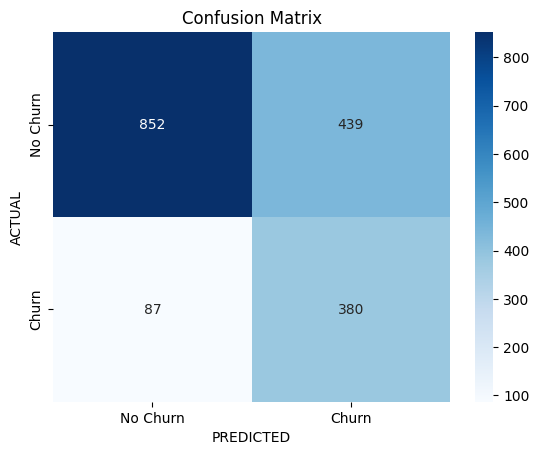


=======================================> PLOTS <=========================================


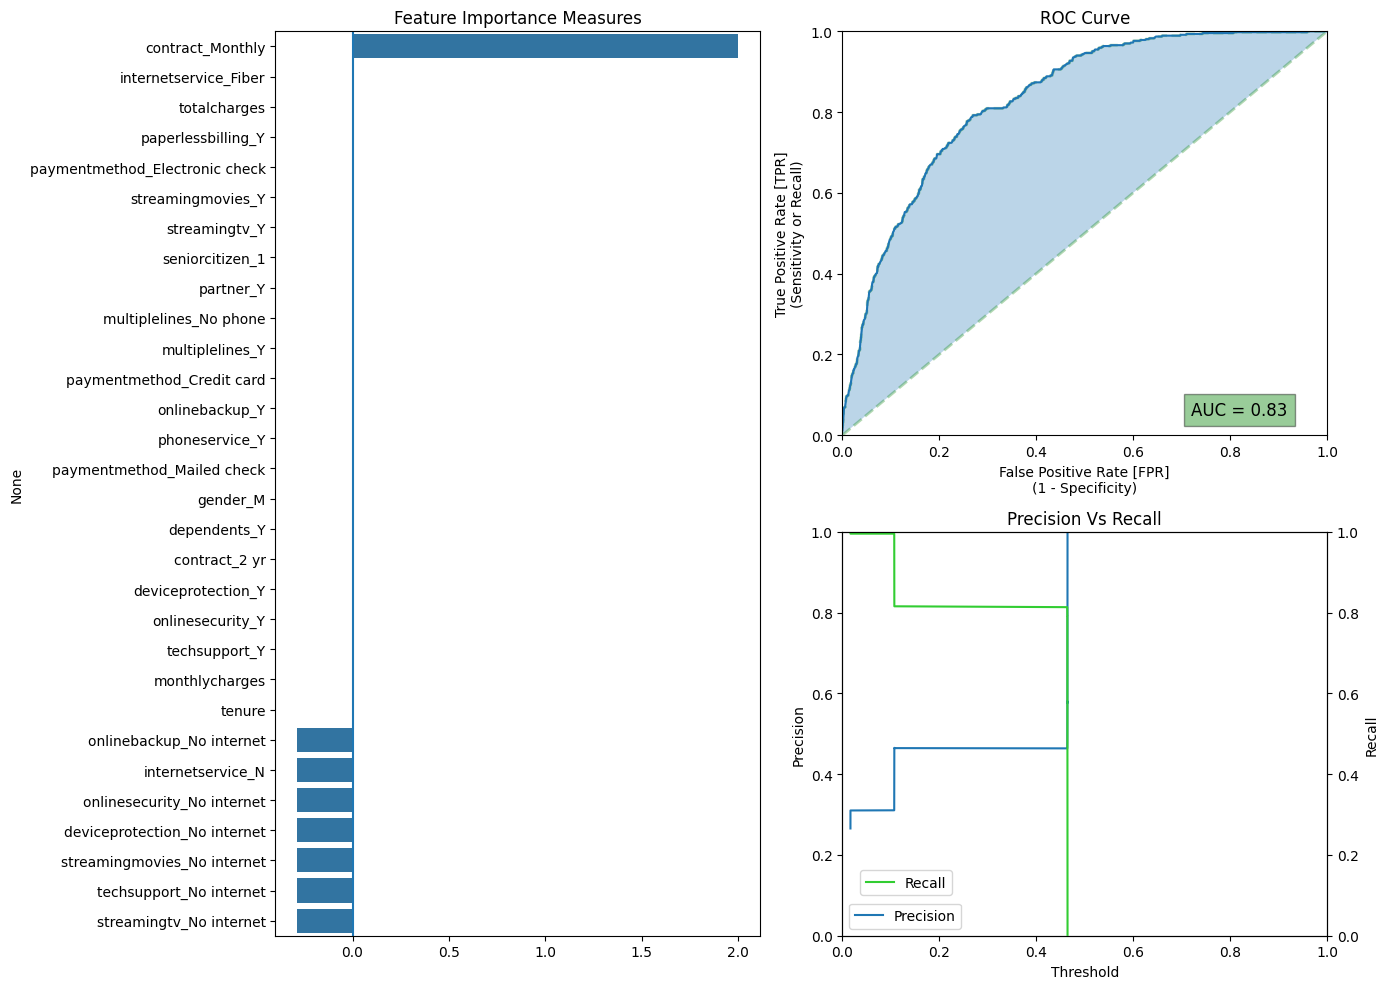

In [100]:
from sklearn.svm import SVC

linear_svc = SVC(kernel='linear', probability=True,
                 class_weight='balanced', random_state=0)

linear_svc, linear_svc_report = report(linear_svc, x_train, y_train,
                                       x_test, y_test,
                                       importance_plot=True,
                                       feature_labels=feature_names,
                                       confusion_labels=confusion_lbs)

<a id="svm-with-rbf-kernel"></a>
## 5.10.  SVM with RBF kernel

SVC(C=0.3, class_weight='balanced', probability=True, random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 5.83 seconds
 Testing Time: 0.34 seconds
------------------------------------------
Train Accuracy:  0.7514220705346986
 Test Accuracy:  0.7417519908987485
------------------------------------------
 Area Under ROC:  0.8294808234242333
------------------------------------------
Model Memory Size: 733.03 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

    No Churn       0.90      0.73      0.81      1291
       Churn       0.51      0.77      0.61       467

    accuracy                           0.74      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.79      0.74      0.75      1758


====

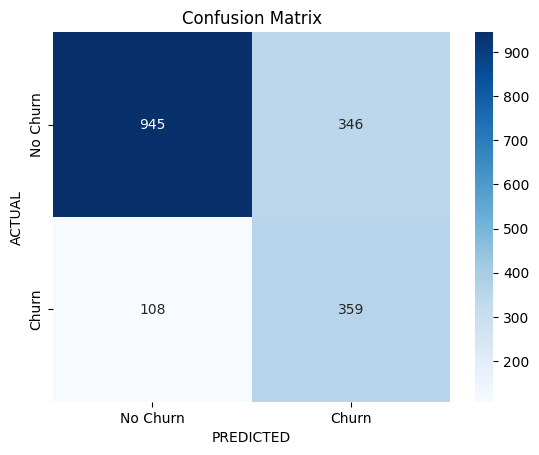


=======================================> PLOTS <=========================================


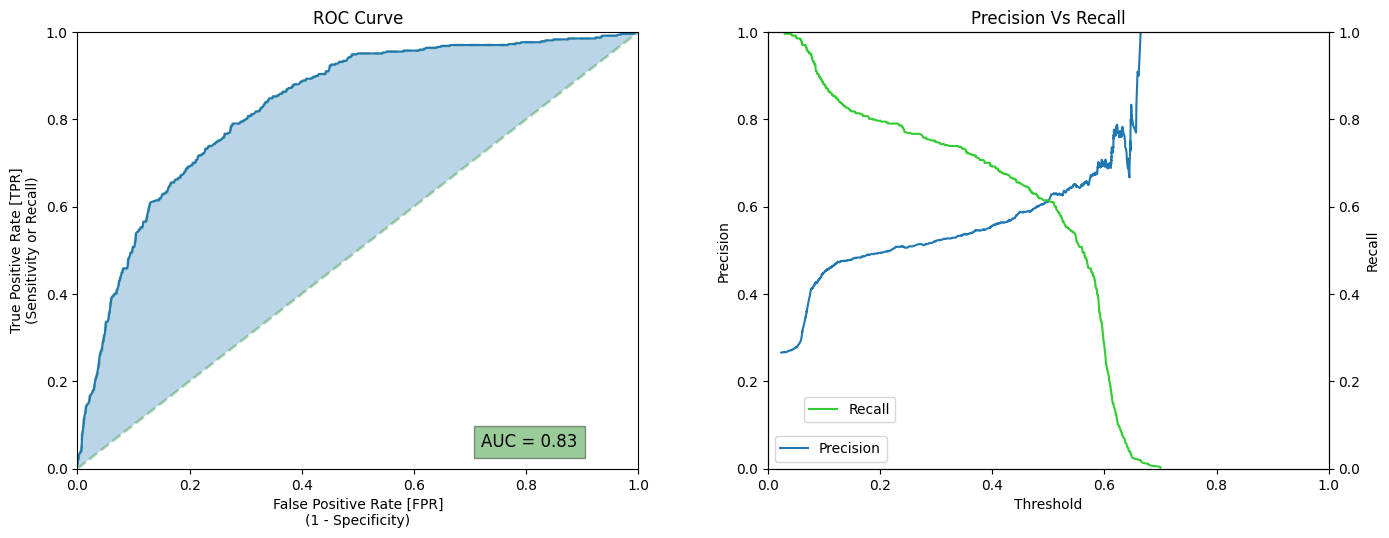

In [101]:
rbf_svc = SVC(C=0.3, kernel='rbf', probability=True,
              class_weight='balanced', random_state=0)

rbf_svc, rbf_svc_report = report(rbf_svc, x_train, y_train,
                                 x_test, y_test,
                                 importance_plot=True,
                                 feature_labels=feature_names,
                                 confusion_labels=confusion_lbs)

<a id="xgboost"></a>
## 5.11.  XGBoost

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 5274 samples
 Test Size: 1758 samples
------------------------------------------
Training Time: 0 seconds
 Testing Time: 0.011 seconds
---------

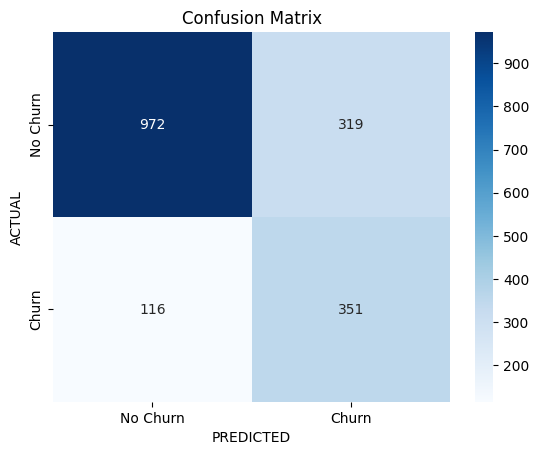


=======================================> PLOTS <=========================================


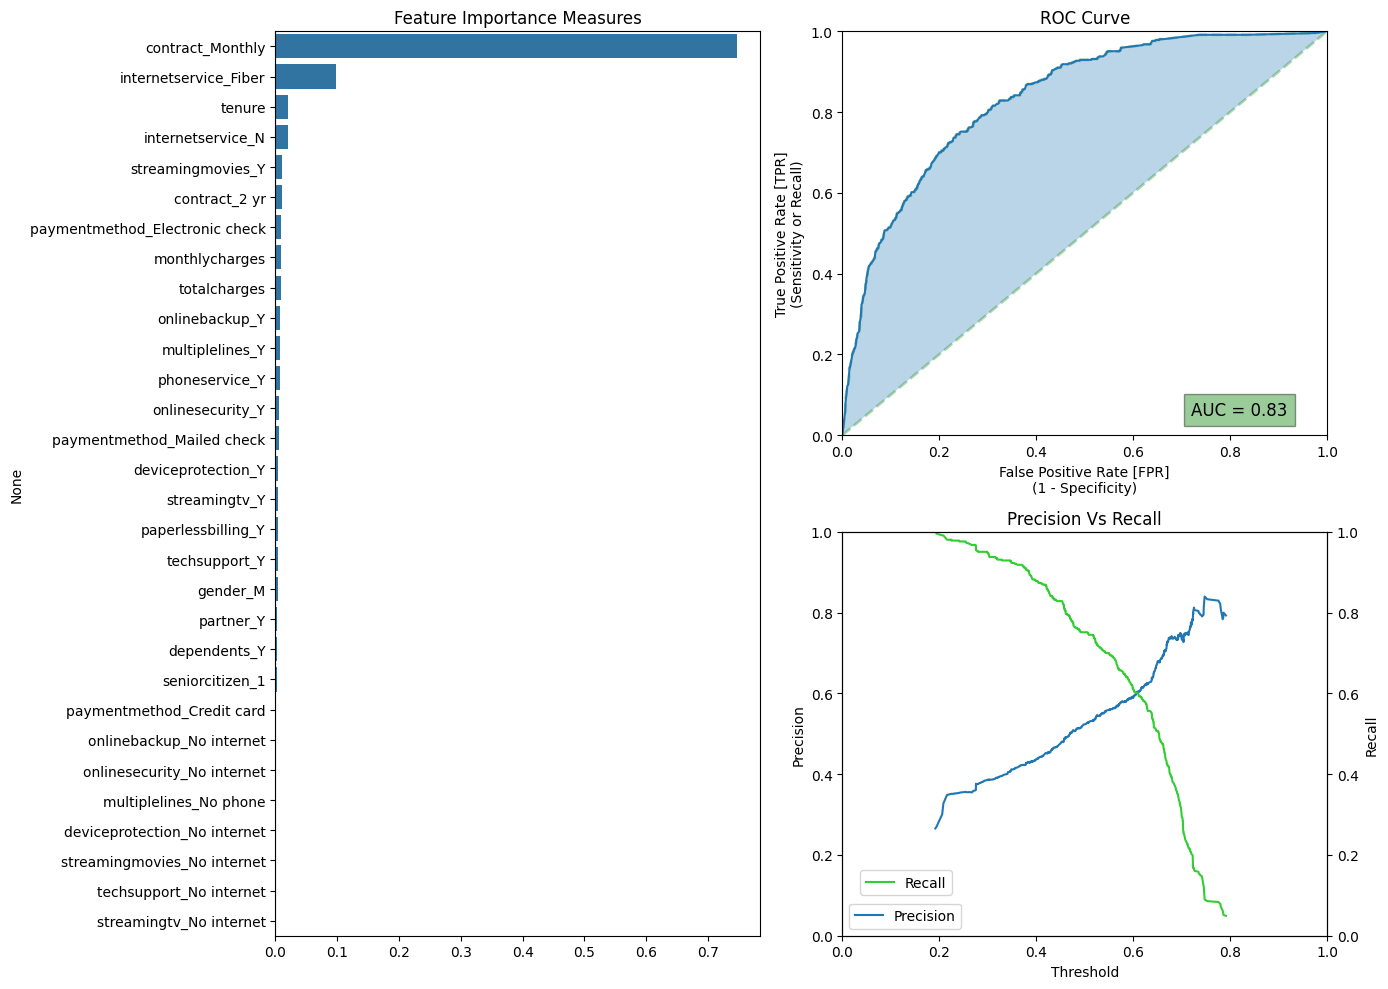

In [102]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight

## Compute `class_weights` using sklearn
cls_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train)

xgb_clf = XGBClassifier(learning_rate=0.01, random_state=0,
                        scale_pos_weight=cls_weight, n_jobs=-1)
xgb_clf.fit(x_train, y_train);

xgb_clf, xgb_report = report(xgb_clf, x_train, y_train,
                             x_test, y_test,
                             importance_plot=True,
                             feature_labels=feature_names,
                             confusion_labels=confusion_lbs)

<a id="catboost"></a>
## 5.12.  CatBoost
Cat boost performs better without One-hot encoding because it performs an internal categorical encoding that is similar to Leave One Out Encoding (LOOE). So, we can give the dataframe as input to the catboost classifier.

In [108]:
# !pip install catboost

In [118]:
!pip install numpy==1.26.4


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [124]:
from catboost import CatBoostClassifier

# Basic working

catboost_clf = CatBoostClassifier(cat_features=categorical_columns,
                                  l2_leaf_reg=120, depth=6,
                                  auto_class_weights='Balanced',
                                  iterations=200, learning_rate=0.16,
                                  use_best_model=True,
                                  early_stopping_rounds=150,
                                  eval_metric='F1', random_state=0)

catboost_clf.fit(x_train_cat, y_train, 
                 eval_set=(x_train_cat, y_train),
                 verbose=False)


f_labels = categorical_columns+numeric_columns
catboost_clf, catboost_report = report(catboost_clf, x_train_cat, y_train,
                                       x_test_cat, y_test,
                                       importance_plot=True,
                                       feature_labels=f_labels,
                                       confusion_labels=confusion_lbs)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

<a id="model-comparison"></a>
# 6.  Model Comparison
Since input data format for Naive Bayes and CatBoost are different, we will add them to the comparison manually.

In [125]:
report_list = [nb_report, logit_report, knn_report, decision_tree_report,               
               bagging_clf_report, random_forest_report, adaboot_report,
               xgb_report, linear_svc_report, rbf_svc_report]  #, catboost_report
clf_labels = [rep['clf'].__class__.__name__ for rep in report_list]
clf_labels[-3], clf_labels[-2] = 'Linear SVC', 'RBF SVC'

<a id="evaluation-metrics"></a>
## 6.1.  Evaluation Metrics

In [126]:
compare_table, compare_plot = compare_models(y_test, clf_reports=report_list, labels=clf_labels)

compare_table.sort_values(by=['Overfitting'])

,Train Accuracy,Test Accuracy,Overfitting,ROC Area,Precision,Recall,F1-score,Support
LogisticRegressionCV,0.751,0.751,False,0.844624,0.521368,0.783726,0.626176,467.0
RandomForestClassifier,0.7,0.7,False,0.833962,0.463504,0.815846,0.591156,467.0
RBF SVC,0.7,0.701,False,0.832447,0.46398,0.813704,0.59098,467.0
CategoricalNB,0.739,0.738,True,0.821244,0.504098,0.79015,0.615513,467.0
KNeighborsClassifier,0.8,0.797,True,0.842938,0.630952,0.567452,0.59752,467.0
DecisionTreeClassifier,0.753,0.75,True,0.81769,0.521084,0.740899,0.611848,467.0
BaggingClassifier,0.748,0.743,True,0.837233,0.511594,0.755889,0.610199,467.0
AdaBoostClassifier,0.749,0.746,True,0.847724,0.513587,0.809422,0.628429,467.0
Linear SVC,0.787,0.753,True,0.834909,0.523881,0.751606,0.617414,467.0
SVC,0.751,0.742,True,0.829481,0.50922,0.768737,0.612628,467.0


***Inference:*** We can see that among the classifiers that do not overfit, Random Forests classifier has the highest recall while Logistic Regression has the highest F1-score. In terms of Revenue Retained, Random Forests are the best. However, Random Forests suffer from low precision.

<a id="roc-and-pr-curves"></a>
## 6.2. ROC and PR Curves

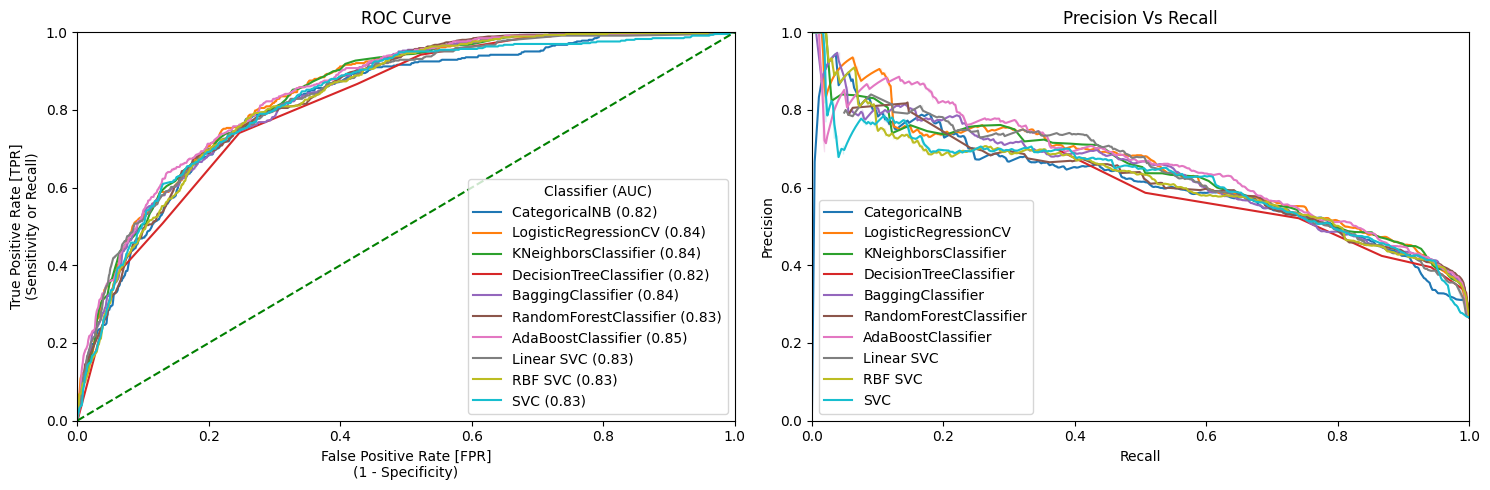

In [127]:
compare_plot

<a id="further-analysis"></a>
# 7.  Further Analysis
We defined a additional evaluation metrics called `Percentage Monthly Revenue Retained` which is defined as,
  
\begin{align}
\text {Revenue Retained (Monthly)} \%=\frac{\sum_{i=1}^{n_{\text {test}}} y_{\text {test}}^{(i)} \times y_{\text {pred}}^{(i)} \times \text {monthlycharges}^{(i)}}{\sum_{i=1}^{n_{\text {test}}} y_{\text {test}}^{(i)} \times \text {monthlycharges}(i)} \times 100
\end{align}

and `Percentage Total Revenue Retained` (over the complete tenure of the customer),

\begin{align}
\text {Revenue Retained (Total) } \%=\frac{\sum_{i=1}^{n_{\text {test}}} y_{\text {test}}^{(i)} \times y_{\text {pred}}^{(i)} \times \text {totalcharges}^{(i)}}{\sum_{i=1}^{n_{\text {test}}} y_{\text {test}}^{(i)} \times \text {totalcharges}^{(i)}} \times 100
\end{align}  
  
These are “revenue” weighted recall scores and can be viewed as a business equivalent of Recall. They represent the revenue retained (or saved) by a model as a result of its correct churn predictions i.e., True Positives.

Similarly, `Revenue Retained (Monthly) per true churn customer` is defined as,

\begin{align}
\text {Revenue Retained (Monthly) per churn customer }=\frac{\sum_{i=1}^{n_{\text {test}}} y_{\text {test}}^{(i)} \times y_{\text {pred}}^{(i)} \times \text {monthlycharges}^{(i)}}{\sum_{i=1}^{n_{\text {test}}} y_{\text {test}}^{(i)} \times y_{\text {pred}}^{(i)}} \times 100
\end{align}  
  
This metric indicates how well a classifier is able to identify Most Valued Customers (MVC) or high spending customers. A high value indicates that a classifier was good at identifying more MVCs than a classifier with a lower value of this metric.  
  
***Note:*** In the following pandas frames, the following are the abbreviations:  
> RRM %  => Revenue Retained (Monthly) %  
> RRT % => Revenue Retained (Total) %  
> RRM/customer => Revenue Retained (Monthly) per true churn customer

In [128]:
df_charges = list()
new_cols = ['RRM/customer', 'RRM %', 'RRT %']

for rep in report_list:
    y_pred = rep['test_predictions']
    true_positives = (y_test * y_pred).reshape(y_test.shape[0], 1)
    tp_revenue = (x_test_charges * true_positives).sum(axis=0)
    tp_revenue = np.insert(tp_revenue, 0, tp_revenue[0] / true_positives.sum())
    df_charges.append(tp_revenue)

revenue_saved = pd.DataFrame(df_charges, index=clf_labels, 
                             columns=new_cols)

compare_table_rev = pd.concat([compare_table, revenue_saved], axis=1)

## True Positive Revenue/ Total Churn Revenue
total_churn_revenue = (x_test_charges * y_test.reshape(y_test.shape[0], 1)).sum(axis=0)
temp_cols = (compare_table_rev.iloc[:, -2:] / total_churn_revenue) * 100
compare_table_rev.iloc[:, -2:] = temp_cols

In [129]:
compare_table_rev.sort_values(by=['Overfitting'])

,Train Accuracy,Test Accuracy,Overfitting,ROC Area,Precision,Recall,F1-score,Support,RRM/customer,RRM %,RRT %
LogisticRegressionCV,0.751,0.751,False,0.844624,0.521368,0.783726,0.626176,467.0,77.847268,80.909103,60.717482
RandomForestClassifier,0.7,0.7,False,0.833962,0.463504,0.815846,0.591156,467.0,76.688583,82.971437,64.536319
RBF SVC,0.7,0.701,False,0.832447,0.46398,0.813704,0.59098,467.0,76.612368,82.671422,64.477005
CategoricalNB,0.739,0.738,True,0.821244,0.504098,0.79015,0.615513,467.0,76.813957,80.489536,58.436784
KNeighborsClassifier,0.8,0.797,True,0.842938,0.630952,0.567452,0.59752,467.0,79.109623,59.531676,28.480971
DecisionTreeClassifier,0.753,0.75,True,0.81769,0.521084,0.740899,0.611848,467.0,78.011127,76.648838,58.947564
BaggingClassifier,0.748,0.743,True,0.837233,0.511594,0.755889,0.610199,467.0,76.585836,76.770803,48.239706
AdaBoostClassifier,0.749,0.746,True,0.847724,0.513587,0.809422,0.628429,467.0,76.257672,81.855576,62.016566
Linear SVC,0.787,0.753,True,0.834909,0.523881,0.751606,0.617414,467.0,75.843732,75.596160,51.209100
SVC,0.751,0.742,True,0.829481,0.50922,0.768737,0.612628,467.0,76.768663,78.262073,53.470557


In [130]:
select_cols = ['Overfitting', 'F1-score'] + new_cols
compare_table_rev[select_cols].sort_values(by=['Overfitting', 'RRM %'],
                                           ascending=[True, False])

,Overfitting,F1-score,RRM/customer,RRM %,RRT %
RandomForestClassifier,False,0.591156,76.688583,82.971437,64.536319
RBF SVC,False,0.59098,76.612368,82.671422,64.477005
LogisticRegressionCV,False,0.626176,77.847268,80.909103,60.717482
AdaBoostClassifier,True,0.628429,76.257672,81.855576,62.016566
CategoricalNB,True,0.615513,76.813957,80.489536,58.436784
SVC,True,0.612628,76.768663,78.262073,53.470557
BaggingClassifier,True,0.610199,76.585836,76.770803,48.239706
DecisionTreeClassifier,True,0.611848,78.011127,76.648838,58.947564
Linear SVC,True,0.617414,75.843732,75.596160,51.209100
KNeighborsClassifier,True,0.59752,79.109623,59.531676,28.480971


In [131]:
compare_table_rev[select_cols].sort_values(by=['Overfitting', 'RRM/customer'],
                                           ascending=[True, False])

,Overfitting,F1-score,RRM/customer,RRM %,RRT %
LogisticRegressionCV,False,0.626176,77.847268,80.909103,60.717482
RandomForestClassifier,False,0.591156,76.688583,82.971437,64.536319
RBF SVC,False,0.59098,76.612368,82.671422,64.477005
KNeighborsClassifier,True,0.59752,79.109623,59.531676,28.480971
DecisionTreeClassifier,True,0.611848,78.011127,76.648838,58.947564
CategoricalNB,True,0.615513,76.813957,80.489536,58.436784
SVC,True,0.612628,76.768663,78.262073,53.470557
BaggingClassifier,True,0.610199,76.585836,76.770803,48.239706
AdaBoostClassifier,True,0.628429,76.257672,81.855576,62.016566
Linear SVC,True,0.617414,75.843732,75.596160,51.209100


<a id="which-model-to-choose%3F"></a>
# 8.  Which model to choose?
Lets consider only the non-overfitting classifiers.

Since Logistic Regression has the best F1-score, it has the best overall performance and hence gives the right tradeoff between precision and recall. ***It can also be seen that Logistic Regression retains a significant portion of the monthly revenue in spite of having lower recall than linear SVC and Random Forests. This shows that most of the customers identified by Logistic Regression have higher monthly expenses.*** In other words, even though Logistic Regression was able to correctly identify fewer churn customers, the churn customers it has identified have higher monthly charges, hence giving Logistic Regression a `RRM %` that is close to Random Forests and linear SVC. Logistic Regression's ability to identify high value customers is also indicated by a high `RRM/customer` value.

The reason for the classifiers not achieving higher accuracy scores (like > 95%) is because the **churn and no-churn classes are overlapping** making it difficult for the classifiers to identify a perfect decision boundary without sacrificing either precision or recall. This can be seen from the lmplots in the correlation section.

If the telecom company wants to choose a classifier to deploy in the real world, the company will have to make a tradeoff between the **amount of revenue it wants to retain** and the **amount of revenue it is willing to spend on the customer retention programs**. This tradeoff is a result of the tradeoff between precision and recall. To retain more revenue, the company needs to choose a classifier that has higher recall and lower precision like Random Forests. However, this will result in higher false positives making the company include no-churn customers as well in the retention programs thereby increasing its spending.

However, if the company chooses to retain a decent amount of the revenue while not spending too much on the retention programs, it will have to choose Logistic Regression because it has a higher F1-score and `RRM/customer` while having `RRM %` that is close to Random Forests.